In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import pickle
import sys
import os

sys.path.append(os.path.abspath(".."))
from constants import *

In [ ]:
def load_evaluation_results(dataset, subontology, swissprot_version, method=None, k=None, use_2024_annotations=False, onevsall=False, return_unannotated=False, experimental_only=True):
    """
    Load evaluation results pickle file based on dataset, subontology, and SwissProt version.
    Optionally return the set of unannotated proteins for the given condition/method.

    Args:
        dataset: Dataset name (H30, ATGO, D1)
        subontology: Subontology (BPO, MFO, CCO)
        swissprot_version: SwissProt version
        method: Optional method name to filter by
        k: Optional k value for BlastKNN method
        use_2024_annotations: If True, use the _2024_annotations path
        onevsall: If True, use the one-vs-all path
        return_unannotated: If True, also return the set of unannotated proteins

    Returns:
        Loaded pickle file content (and optionally the set of unannotated proteins)
    """
    base_path = f"../results/{dataset}/baselines_{dataset}_{swissprot_version}_{subontology}"
    if experimental_only:
        base_path += "_exp"
    if swissprot_version == '':
        base_path = f"../results/{dataset}/baselines_{dataset}__{subontology}" # By default, Benchmark setting uses exp annots.
    if use_2024_annotations:
        base_path += "_2024_annotations"
        if onevsall:
            base_path += "_one_vs_all"
    elif onevsall:
        base_path += "_one_vs_all"

    if method == "BlastKNN" and k is not None:
        pattern = f"{base_path}/evaluation/BlastKNN_k{k}/beprof_eval_results.pkl"
    else:
        pattern = f"{base_path}/evaluation/{method}/beprof_eval_results.pkl"
    files = glob.glob(pattern)
    if files == []:
        raise FileNotFoundError(f"Warning: No evaluation results found for {dataset}, {subontology}, {swissprot_version}, use_2024_annotations={use_2024_annotations}, onevsall={onevsall}, experimental_only={experimental_only}, method={method}, k={k} using pattern {pattern}")
    with open(files[0], 'rb') as f:
        results = pickle.load(f)

    # Uncomment the following line to ensure PR curves have proper endpoints
    # results = ensure_pr_endpoints(results)

    if not return_unannotated:
        return results

    # Try to load unannotated proteins set
    unannotated_path = f"{base_path}/unaligned_proteins_{dataset}_{swissprot_version}_{subontology}.txt"
    if os.path.exists(unannotated_path):
        with open(unannotated_path, "r") as uf:
            unannotated = set(line.strip() for line in uf if line.strip())
    else:
        unannotated = set()
    return results, unannotated

def load_ground_truth(dataset, subontology, version=None, return_unannotated=False, experimental_only=True):
    """
    Load ground truth TSV file for a given dataset, subontology, and SwissProt version.
    Optionally return the set of unannotated proteins for the given condition.

    Args:
        dataset: Dataset name (e.g., 'ATGO')
        subontology: Subontology (e.g., 'BPO', 'MFO', 'CCO')
        version: SwissProt version (e.g., '2024_01')
        return_unannotated: If True, also return the set of unannotated proteins

    Returns:
        pandas.DataFrame: Ground truth dataframe (and optionally the set of unannotated proteins)
    """
    exp = '_exp' if experimental_only else ''
    if dataset == 'swissprot':
        gt_path = f"../data/swissprot/{version}/swissprot_{version}_{subontology}{exp}_annotations.tsv"
    else:
        gt_path = f"../data/{dataset}/{dataset}_{subontology}_test_annotations.tsv"
    gt = pd.read_csv(gt_path, sep='\t')
    gt['term'] = gt['term'].str.split('; ')
    gt = gt.explode('term')

    if not return_unannotated:
        return gt

    # Try to load unannotated proteins set
    if dataset == 'swissprot':
        unannotated_path = f"../results/{dataset}/unaligned_proteins_{dataset}_{version}_{subontology}.txt"
    else:
        unannotated_path = f"../results/{dataset}/unaligned_proteins_{dataset}_{subontology}.txt"
    if os.path.exists(unannotated_path):
        with open(unannotated_path, "r") as uf:
            unannotated = set(line.strip() for line in uf if line.strip())
    else:
        unannotated = set()
    return gt, unannotated

def load_predictions(dataset, subontology, version, method, use_2024_annotations=False, onevsall=False, return_unannotated=False, experimental_only=True):
    """
    Load predictions TSV file for a given dataset, subontology, and SwissProt version.
    Optionally return the set of unannotated proteins for the given condition/method.

    Args:
        dataset: Dataset name (e.g., 'ATGO')
        subontology: Subontology (e.g., 'BPO', 'MFO', 'CCO')
        version: SwissProt version (e.g., '2024_01')
        method: Method name (e.g., 'BlastKNN', 'PFP')
        use_2024_annotations: If True, use the _2024_annotations path
        onevsall: If True, use the one-vs-all path
        return_unannotated: If True, also return the set of unannotated proteins

    Returns:
        pandas.DataFrame: Predictions dataframe (and optionally the set of unannotated proteins)
    """
    exp = '_exp' if experimental_only else ''
    pred_path = f"../results/{dataset}/baselines_{dataset}_{version}_{subontology}{exp}/predictions/{method}/predictions.tsv"
    if version == '':
        pred_path = f"../results/{dataset}/baselines_{dataset}_{subontology}/predictions/{method}/predictions.tsv"
    if use_2024_annotations:
        pred_path = f"../results/{dataset}/baselines_{dataset}_{version}_{subontology}{exp}_2024_annotations/predictions/{method}/predictions.tsv"
        if onevsall:
            pred_path = f"../results/{dataset}/baselines_{dataset}_{version}_{subontology}{exp}_2024_annotations_one_vs_all/predictions/{method}/predictions.tsv"
    elif onevsall:
        pred_path = f"../results/{dataset}/baselines_{dataset}_{version}_{subontology}{exp}_one_vs_all/predictions/{method}/predictions.tsv"

    df = pd.read_csv(pred_path, sep='\t')

    if not return_unannotated:
        return df

    # Try to load unannotated proteins set
    base_path = f"../results/{dataset}/baselines_{dataset}_{version}_{subontology}{exp}"
    if use_2024_annotations:
        base_path += "_2024_annotations"
        if onevsall:
            base_path += "_one_vs_all"
    elif onevsall:
        base_path += "_one_vs_all"
    unannotated_path = f"{base_path}/unaligned_proteins_{dataset}_{version}_{subontology}.txt"
    if os.path.exists(unannotated_path):
        with open(unannotated_path, "r") as uf:
            unannotated = set(line.strip() for line in uf if line.strip())
    else:
        unannotated = set()
    return df, unannotated

def ensure_pr_endpoints(results_dict):
    """
    Ensure that precision-recall curves have proper endpoints.
    For recall: should start with 1.0 and end with 0.0
    For precision: should start with 0.0 and end with 1.0
    
    Args:
        results_dict: Dictionary from load_exp_evaluation_results() containing PR curve data
    
    Returns:
        Modified dictionary with endpoints added if necessary
    """
    
    # Define the PR curve pairs to check
    pr_pairs = [
        ('recalls', 'precisions', 'result_aupr'),
        ('icrecalls', 'icprecisions', 'result_icaupr'), 
        ('dprecalls', 'dpprecisions', 'result_dpaupr')
    ]
    
    for recall_key, precision_key, result_key in pr_pairs:
        if recall_key in results_dict and precision_key in results_dict:
            recalls = np.array(results_dict[recall_key])
            precisions = np.array(results_dict[precision_key])
            
            # Check if arrays are not empty
            if len(recalls) == 0 or len(precisions) == 0:
                continue
                
            # Check and add starting endpoint (recall=1.0, precision=0.0)
            if recalls[0] != 0.0:
                recalls = np.concatenate([[0.0], recalls])
                recalls = np.concatenate([recalls, [1.0]])
            
            # Check and add ending endpoint (recall=0.0, precision=1.0)
            if precisions[0] != 1.0:
                precisions = np.concatenate([[1.0], precisions])
                precisions = np.concatenate([precisions, [0.0]])
            
            # Update the dictionary
            results_dict[result_key] = np.trapz(precisions, recalls)
            results_dict[recall_key] = recalls.tolist()
            results_dict[precision_key] = precisions.tolist()
            
    return results_dict

In [8]:
res, unannotated = load_evaluation_results("ATGO", "MFO", "2019_01", method="AlignmentScore", k=20, use_2024_annotations=False, onevsall=True, return_unannotated=True)
res

{'ontology': 'mf',
 'recalls': array([0.42230786, 0.42307414, 0.42307414, 0.42307414, 0.42334459,
        0.42545187, 0.43000747, 0.43234812, 0.43448413, 0.43821366,
        0.44326429, 0.44979187, 0.45218651, 0.45987675, 0.46550322,
        0.47262874, 0.47655321, 0.48034438, 0.48925956, 0.49811652,
        0.50372598, 0.50664515, 0.51133516, 0.5144396 , 0.51608869,
        0.5249013 , 0.53271238, 0.53844402, 0.54535724, 0.54831291,
        0.55133699, 0.55767771, 0.56159534, 0.56983288, 0.57685339,
        0.58059692, 0.58573102, 0.58909614, 0.59263859, 0.59766582,
        0.60019168, 0.60427687, 0.6057129 , 0.60604131, 0.60730393,
        0.61220964, 0.61897454, 0.62398184, 0.62812459, 0.63388555,
        0.64324652, 0.6486402 , 0.65197901, 0.65576117, 0.65827908,
        0.66141263, 0.66543677, 0.66770089, 0.66942502, 0.67188808,
        0.673682  , 0.67685551, 0.67813928, 0.68192925, 0.68668236,
        0.69320125, 0.69422296, 0.70045899, 0.70498083, 0.70670314,
        0.70980468

## ATGO Paper - Result Comparison

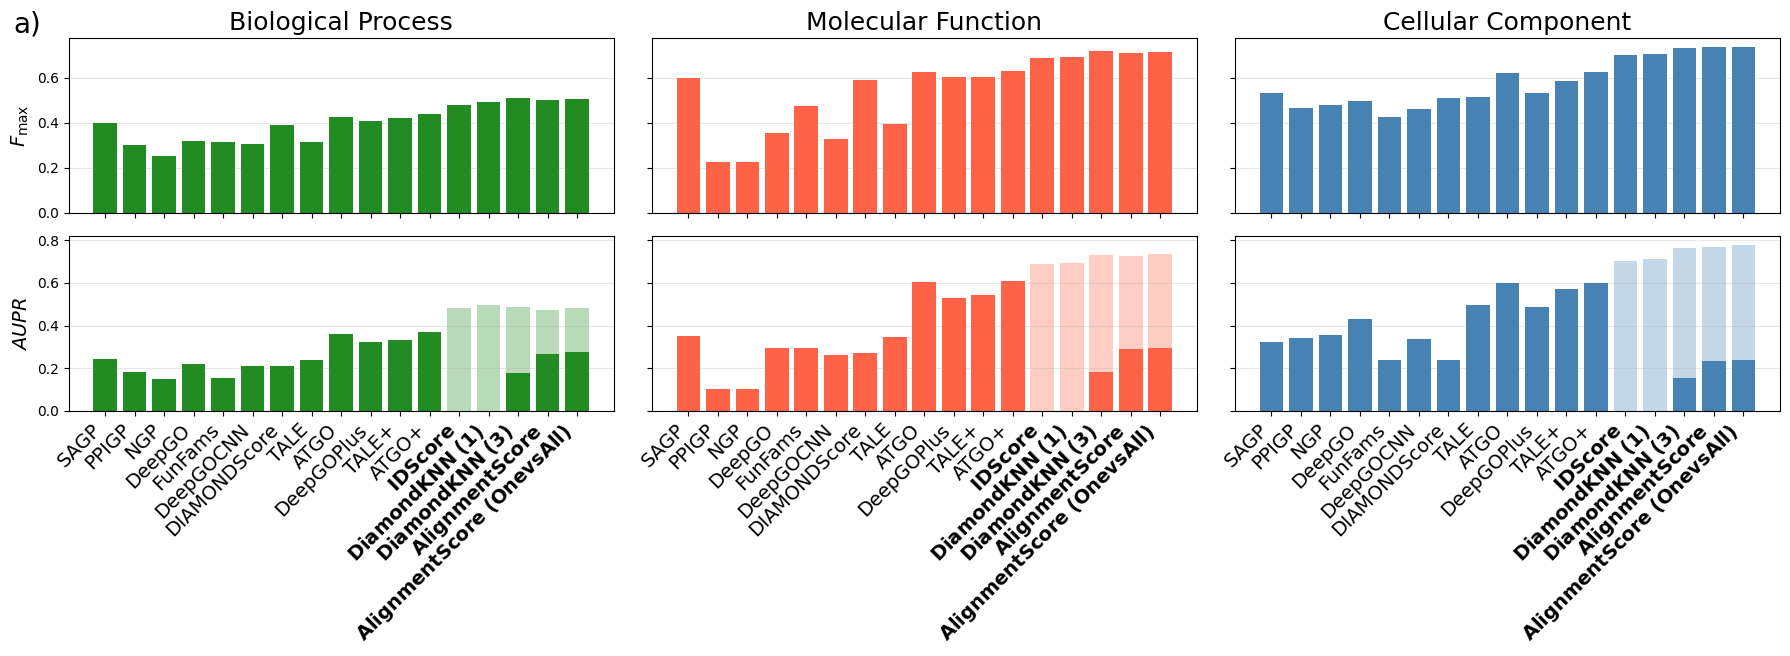

In [ ]:
methods = [
    "SAGP", "PPIGP", "NGP", "DeepGO", "FunFams", "DeepGOCNN", "DIAMONDScore", "TALE", "ATGO",
    "DeepGOPlus", "TALE+", "ATGO+", "IDScore", "DiamondKNN (1)", "DiamondKNN (3)", "AlignmentScore", "AlignmentScore (OnevsAll)"
]
bold_methods = {"IDScore", "DiamondKNN (1)", "DiamondKNN (3)", "AlignmentScore", "AlignmentScore (OnevsAll)"}
metric_form = {
    'Fmax': r'$F_{\max}$',
    'Smin': r'$S_{\min}$',
    'AUPR': r'$AUPR$',
    'IC-AUPR': r'$IC-AUPR$',
    'DP-AUPR': r'$DP-AUPR$'
}

fmax = {
    "MFO": [0.597, 0.224, 0.224, 0.355, 0.476, 0.328, 0.592, 0.393, 0.627, 0.603, 0.602, 0.631, 0.6887298227907048, 0.693828687450248, 0.7171264380559853, 0.7110490839953149, 0.7140143471699203],
    "BPO": [0.400, 0.303, 0.254, 0.317, 0.315, 0.307, 0.391, 0.315, 0.425, 0.409, 0.420, 0.438, 0.480069021788829, 0.49156110804304465, 0.5080210515532743, 0.5016786156788374, 0.5078190534768207],
    "CCO": [0.534, 0.467, 0.481, 0.499, 0.424, 0.463, 0.511, 0.516, 0.623, 0.533, 0.586, 0.624, 0.6999206974487738, 0.7073508884184363, 0.7326244604612286, 0.7358277589056892, 0.738334273325351]
}
aupr = {
    "MFO": [0.351, 0.103, 0.103, 0.293, 0.294, 0.264, 0.272, 0.344, 0.603, 0.528, 0.542, 0.611, np.nan, np.nan, 0.1827891171130881, 0.287818693909898, 0.2944268575759845],
    "BPO": [0.242, 0.181, 0.151, 0.218, 0.152, 0.208, 0.209, 0.236, 0.361, 0.323, 0.332, 0.368, np.nan, np.nan, 0.17837718892437912, 0.2683610528556447,  0.27589720809750257],
    "CCO": [0.322, 0.340, 0.355, 0.430, 0.236, 0.337, 0.239, 0.496, 0.600, 0.486, 0.569, 0.600, np.nan, np.nan, 0.15319399388038626, 0.2354386635423839, 0.23945286530813145]
}

aupr_corr = {
    "MFO": [0,0,0,0,0,0,0,0,0,0,0,0,0.6893567321974847, 0.6948670181901695, 0.7321038097043946, 0.7259288953759434, 0.7335141531663133],
    "BPO": [0,0,0,0,0,0,0,0,0,0,0,0,0.4813278626174144, 0.49502426004415523, 0.48463664949751384, 0.4749422785621933, 0.48328994840984657],
    "CCO": [0,0,0,0,0,0,0,0,0,0,0,0,0.7034701397181269, 0.7124090312511993, 0.7619883251146988, 0.7699025520466847, 0.779192219623704]
}

import matplotlib.colors as mcolors

def lighten_color(color, amount=0.5):
    """
    Lighten the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgb(c)
    return tuple(1 - amount * (1 - x) for x in c)

SUBONTOLOGIES_COLORS = {"BPO": "forestgreen", "MFO": "tomato", "CCO": "steelblue"}

metrics = [("Fmax", fmax), ("AUPR", aupr)]
corrected_metrics = {
    "AUPR": aupr_corr,
}
fig, axes = plt.subplots(len(metrics), 3, figsize=(18, 7), sharey='row')
for row, (metric_name, metric_dict) in enumerate(metrics):
    for col, ontology in enumerate(["BPO", "MFO", "CCO"]):
        ax = axes[row, col]
        ax.grid(True, axis='y', alpha=0.3)
        values = metric_dict[ontology]
        base_color = SUBONTOLOGIES_COLORS[ontology]
        bars = ax.bar(methods, values, color=[base_color]*len(methods), zorder=2)

        if metric_name in corrected_metrics:
            corr_values = corrected_metrics[metric_name][ontology]
            light_color = lighten_color(base_color, 0.4)
            ax.bar(methods, corr_values, color=[light_color]*len(methods), alpha=0.8, zorder=1, label='Corrected' if col == 0 and row == 1 else None)

        labels = []
        for m in methods:
            if m in bold_methods:
                labels.append(r"$\bf{" + m.replace(" ", "\ ") + "}$")
            else:
                labels.append(m)
        if row == len(metrics) - 1:
            ax.set_xticks(range(len(methods)))
            ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=14)
        else:
            ax.set_xticks(range(len(methods)))
            ax.set_xticklabels([])
            ax.set_xlabel("")
        if col == 0:
            ax.set_ylabel(metric_form[metric_name], fontsize=14)
        else:
            ax.set_ylabel("")
        if row == 0:
            ax.set_title(f"{SUBONTOLOGIES_LABELS[ontology]}", fontsize=18)
        else:
            ax.set_title("")

handles, labels_ = [], []
handles.append(plt.Rectangle((0,0),1,1, color=SUBONTOLOGIES_COLORS["MFO"]))
labels_.append("Original")
handles.append(plt.Rectangle((0,0),1,1, color=lighten_color(SUBONTOLOGIES_COLORS["MFO"], 0.4)))
labels_.append("Corrected")
# fig.legend(handles, labels_, loc='lower center', ncol=len(labels_), bbox_to_anchor=(0.5, -0.01))
fig.text(0.01, 0.98, 'a)', fontsize=20, va='top', ha='left')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


## D1 Paper - Result Comparison

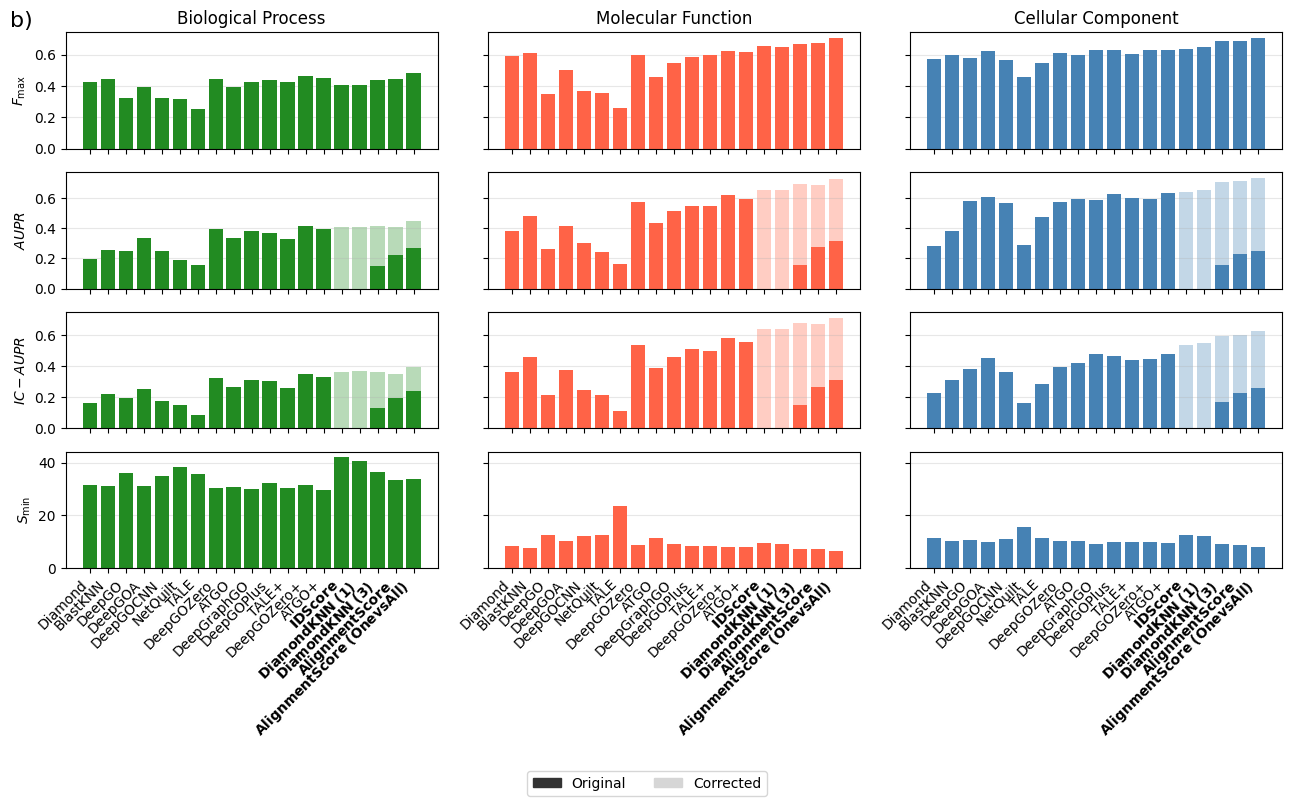

In [ ]:
methods = [
    "Diamond", "BlastKNN", "DeepGO", "DeepGOA", "DeepGOCNN", "NetQuilt", "TALE", 
    "DeepGOZero", "ATGO", "DeepGraphGO", "DeepGOPlus", "TALE+", "DeepGOZero+", "ATGO+",
    "IDScore", "DiamondKNN (1)", "DiamondKNN (3)", "AlignmentScore", "AlignmentScore (OnevsAll)"
]
bold_methods = {"IDScore", "DiamondKNN (1)", "DiamondKNN (3)", "AlignmentScore", "AlignmentScore (OnevsAll)"}
metric_form = {
    'Fmax': r'$F_{\max}$',
    'Smin': r'$S_{\min}$',
    'AUPR': r'$AUPR$',
    'IC-AUPR': r'$IC-AUPR$',
    'DP-AUPR': r'$DP-AUPR$'
}

fmax = {
    "MFO": [0.589, 0.614, 0.352, 0.500, 0.367, 0.358, 0.258, 0.600, 0.455, 0.548, 0.586, 0.597, 0.623, 0.619,
            0.6553473207741957, 0.6520570825097611, 0.67112916560604, 0.6777754512880938, 0.7070643757186961],
    "CCO": [0.572, 0.595, 0.579, 0.621, 0.563, 0.458, 0.549, 0.613, 0.599, 0.633, 0.630, 0.607, 0.633, 0.630,
            0.6352075370709896, 0.6473710566061011, 0.6881045563492207, 0.6852370002306173, 0.7077784984118985],
    "BPO": [0.426, 0.443, 0.321, 0.393, 0.323, 0.316, 0.256, 0.443, 0.395, 0.427, 0.437, 0.426, 0.463, 0.454,
            0.40339444277679726, 0.4072452016529648, 0.43912016343847626, 0.4454718796655369, 0.48408380835748466]
}

smin = {
    "MFO": [8.303, 7.852, 12.442, 10.391, 12.070, 12.610, 23.495, 8.790, 11.375, 9.197, 8.515, 8.375, 8.193, 8.048,
            9.446483576379805, 9.104429240490951, 7.243672029760697, 7.298965282541176, 6.661581736705445],
    "CCO": [11.548, 10.182, 10.646, 9.829, 11.092, 15.536, 11.546, 10.451, 10.192, 9.295, 10.021, 10.019, 10.062, 9.671,
            12.43604319420183, 12.084025462338053, 9.0247940662139, 8.683472071340855, 8.065644970781124],
    "BPO": [31.502, 31.319, 36.028, 31.323, 34.986, 38.374, 35.548, 30.330, 30.893, 29.988, 32.419, 30.354, 31.687, 29.667,
            41.96726315152877, 40.69540240649641, 36.55685803385337, 33.32434772451867, 33.78305466677647]
}

aupr = {
    "MFO": [0.384, 0.482, 0.265, 0.414, 0.302, 0.245, 0.160, 0.576, 0.437, 0.515, 0.548, 0.545, 0.618, 0.593,
            0.0, 0.0, 0.15394620000696185, 0.27757264983151, 0.31856487858754645],
    "CCO": [0.281, 0.383, 0.583, 0.610, 0.570, 0.287, 0.476, 0.572, 0.596, 0.586, 0.625, 0.598, 0.592, 0.634,
            0.0, 0.0, 0.15774012243245708, 0.2260762368047531, 0.2503155046193256],
    "BPO": [0.195, 0.257, 0.251, 0.337, 0.251, 0.191, 0.155, 0.393, 0.338, 0.381, 0.366, 0.327, 0.412, 0.396,
            0.0, 0.0, 0.14992029585103767, 0.22557643055191373, 0.2672491753150715]
}

icaupr = {
    "MFO": [0.360, 0.457, 0.215, 0.376, 0.244, 0.212, 0.112, 0.538, 0.387, 0.458, 0.508, 0.497, 0.581, 0.555,
            0.0, 0.0, 0.14908450667030143, 0.26663353892795655, 0.31119499480808965],
    "CCO": [0.229, 0.308, 0.384, 0.452, 0.360, 0.164, 0.287, 0.392, 0.423, 0.479, 0.467, 0.440, 0.446, 0.478,
            0.0, 0.0, 0.16809149553188824, 0.2271562242730726, 0.25680675438381306],
    "BPO": [0.165, 0.218, 0.195, 0.252, 0.175, 0.150, 0.085, 0.325, 0.265, 0.314, 0.303, 0.261, 0.349, 0.328,
            0.0, 0.0, 0.13164781310445078, 0.1969507155830202, 0.24122581993535774]
}

dpaupr = {
    "MFO": [0.345, 0.426, 0.171, 0.323, 0.195, 0.183, 0.078, 0.510, 0.341, 0.412, 0.478, 0.468, 0.554, 0.522,
            0.6207467225152274, 0.6167043648147135, 0.6541495850807002, 0.6437793707789559, 0.6884551362599989],
    "CCO": [0.227, 0.303, 0.367, 0.438, 0.342, 0.156, 0.268, 0.384, 0.409, 0.468, 0.455, 0.425, 0.437, 0.466,
            0.5327321302794382, 0.5472696287002458, 0.5913595146607329, 0.5915900852662911, 0.6221156172272139],
    "BPO": [0.154, 0.202, 0.154, 0.218, 0.144, 0.134, 0.063, 0.298, 0.232, 0.286, 0.277, 0.234, 0.324, 0.299,
            0.3424648326773415, 0.34939654884033633, 0.3396979709935321, 0.32954875624679064, 0.37578634402755284]
}

# D1 corrected metrics
icaupr_corr = {
    "MFO": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.6404706574638322, 0.6366560090321534, 0.6761694818707964, 0.6695305604119866, 0.7125595125840026],
    "BPO": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.36079104022462305, 0.36637934285853424, 0.36146548608058787, 0.3520654779060026, 0.39750026119545107],
    "CCO": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5378161351210496, 0.5518534687611788, 0.5971961051006806, 0.5976788397616579, 0.6279139754874449]
}
dpaupr_corr = {
    "MFO": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.6207467225152274, 0.6167043648147135, 0.6541495850807002, 0.6437793707789559, 0.6884551362599989],
    "BPO": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.3424648326773415, 0.34939654884033633, 0.3396979709935321, 0.32954875624679064, 0.37578634402755284],
    "CCO": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5327321302794382, 0.5472696287002458, 0.5913595146607329, 0.5915900852662911, 0.6221156172272139]
}
aupr_corr = {
    "MFO": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.657158387340962, 0.6541951838512846, 0.6923856081570681, 0.6866969780419198, 0.7266554126398119],
    "BPO": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.4059076177594466, 0.4103749105341594, 0.4134755672156976, 0.40642314266866336, 0.44655264973767533],
    "CCO": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.6410145516694278, 0.6529477989131309, 0.709443208398073, 0.7135553349074242, 0.7359750897381306]
}

import matplotlib.colors as mcolors

def lighten_color(color, amount=0.5):
    """
    Lighten the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgb(c)
    return tuple(1 - amount * (1 - x) for x in c)

SUBONTOLOGIES_COLORS = {"BPO": "forestgreen", "MFO": "tomato", "CCO": "steelblue"}

metrics = [("Fmax", fmax), ("AUPR", aupr), ("IC-AUPR", icaupr), ("Smin", smin)]
corrected_metrics = {
    "AUPR": aupr_corr,
    "IC-AUPR": icaupr_corr,
    "DPAUPR": dpaupr_corr,
}
fig, axes = plt.subplots(len(metrics), 3, figsize=(13, 8), sharey='row')
for row, (metric_name, metric_dict) in enumerate(metrics):
    for col, ontology in enumerate(["BPO", "MFO", "CCO"]):
        ax = axes[row, col]
        ax.grid(True, axis='y', alpha=0.3)
        values = metric_dict[ontology]
        base_color = SUBONTOLOGIES_COLORS[ontology]
        bars = ax.bar(methods, values, color=[base_color]*len(methods), zorder=2)

        # Overlay corrected metric histogram if available
        if metric_name in corrected_metrics:
            corr_values = corrected_metrics[metric_name][ontology]
            light_color = lighten_color(base_color, 0.4)
            ax.bar(methods, corr_values, color=[light_color]*len(methods), alpha=0.8, zorder=1, label='Corrected' if col == 0 and row == 1 else None)

        labels = []
        for m in methods:
            if m in bold_methods:
                labels.append(r"$\bf{" + m.replace(" ", "\ ") + "}$")
            else:
                labels.append(m)
        if row == len(metrics) - 1:
            ax.set_xticks(range(len(methods)))
            ax.set_xticklabels(labels, rotation=45, ha='right')
        else:
            ax.set_xticks(range(len(methods)))
            ax.set_xticklabels([])
            ax.set_xlabel("")
        if col == 0:
            ax.set_ylabel(metric_form[metric_name])
        else:
            ax.set_ylabel("")
        if row == 0:
            ax.set_title(f"{SUBONTOLOGIES_LABELS[ontology]}")
        else:
            ax.set_title("")

handles, labels_ = [], []
dark_gray = (0.2, 0.2, 0.2)
light_gray = (0.6, 0.6, 0.6)
handles.append(plt.Rectangle((0,0),1,1, color=dark_gray))
labels_.append("Original")
handles.append(plt.Rectangle((0,0),1,1, color=lighten_color(light_gray, 0.4)))
labels_.append("Corrected")
fig.legend(handles, labels_, loc='lower center', ncol=len(labels_), bbox_to_anchor=(0.5, -0.01))
fig.text(0.01, 0.98, 'b)', fontsize=16, va='top', ha='left')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

## Evolution over SwissProt versions

In [ ]:
def plot_metric_evolution(
    datasets,
    metric='result_fmax',
    coverage=False,
    conditions=None,
):
    """
    Create three separate plots comparing different conditions for Fmax evolution.
    Each plot compares the benchmark condition against one other condition.
    """
    metric_name = {
        'result_fmax': r'$F_{\max}$',
        'result_smin': r'$S_{\min}$',
        'result_aupr': r'$AUPR$',
        'result_icaupr': r'$IC-AUPR$',
        'result_dpaupr': r'$DP-AUPR$'
    }
    # Redline values for "Original Paper"
    original_paper_values = {
        "result_fmax": {
            "D1": {"BPO": 0.426, "MFO": 0.589, "CCO": 0.572},
            "ATGO": {"BPO": 0.391, "MFO": 0.592, "CCO": 0.511},
            # "CAFA3": {"BPO": 0.45, "MFO": 0.456, "CCO": 0.464}, # ATGO paper, full cafa3 benchmark
        },
        "result_icaupr": {
            "D1": {"BPO": 0.165, "MFO": 0.360, "CCO": 0.229},
        },
        "result_aupr": {
            "D1": {"BPO": 0.195, "MFO": 0.384, "CCO": 0.281},
            "ATGO": {"BPO": 0.209, "MFO": 0.272, "CCO": 0.239},
            # "CAFA3": {"BPO": 0.268, "MFO": 0.199, "CCO": 0.238}, # ATGO paper, full cafa3 benchmark
        },
        "result_dpaupr": {
            "D1": {"BPO": 0.154, "MFO": 0.345, "CCO": 0.227},
        },
        "result_smin": {
            "D1": {"BPO": 31.502, "MFO": 8.303, "CCO": 11.548},
        },
    }
    all_handles = []
    all_labels = []

    for dataset, tag in zip(datasets, ['a)', 'b)', 'c)', 'd)']):

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.text(0.01, 0.98, f'{tag} {dataset}', fontsize=16, va='top', ha='left')

        for i, subontology in enumerate(SUBONTOLOGIES):
            ax = axes[i]
            if coverage:
                ax2 = ax.twinx()
                
            # --- Compute Benchmark value ---
            try:
                benchmark_exp_results = load_evaluation_results(
                    dataset, subontology, '', method='AlignmentScore',
                    use_2024_annotations=False, onevsall=False, experimental_only=True,
                )
                benchmark_exp_value = benchmark_exp_results.get(metric, np.nan)
            except Exception:
                benchmark_exp_value = np.nan
            if not np.isnan(benchmark_exp_value):
                hline = ax.axhline(benchmark_exp_value, color='black', linestyle=':', linewidth=1.5, label='Benchmark')
                if i == 0:  # Only add the Benchmark line once
                    all_handles.append(hline)
                    all_labels.append('Benchmark')

            # Plot thin red hline for "Original Paper" - if available for this metric
            if metric in original_paper_values and dataset in original_paper_values[metric] and subontology in original_paper_values[metric][dataset]:
                red_value = original_paper_values[metric][dataset][subontology]
                redline = ax.axhline(red_value, color='red', linestyle=':', linewidth=1, label='Original Paper')
                if i == 0:  # Only add the Original Paper line once
                    all_handles.append(redline)
                    all_labels.append('Original Paper')
            # ---------------------------------------------------------
            for condition in conditions:
                fmax_scores = []
                unannotated_percentages = []
                valid_versions = []
                for version in SWISSPROT_VERSIONS:
                    try:
                        if coverage:
                            results, unannotated = load_evaluation_results(
                                dataset, subontology, version, method=condition["method"],
                                use_2024_annotations=condition["use_2024_annotations"],
                                onevsall=condition["onevsall"],
                                return_unannotated=True,
                                experimental_only=condition["experimental_only"],
                                k=condition.get("k", None)
                            )
                            gt = load_ground_truth(dataset, subontology, experimental_only=condition["experimental_only"])
                            total_proteins = len(gt['EntryID'].unique())
                            unannotated_pct = (len(unannotated) / total_proteins) * 100 if total_proteins > 0 else 0
                        else:
                            results = load_evaluation_results(
                                dataset, subontology, version, method=condition["method"],
                                use_2024_annotations=condition["use_2024_annotations"],
                                onevsall=condition["onevsall"],
                                experimental_only=condition["experimental_only"],
                                k=condition.get("k", None)
                            )
                            unannotated_pct = None  # Not used if not coverage

                        fmax = results.get(metric, np.nan)
                        if not np.isnan(fmax):
                            fmax_scores.append(fmax)
                            valid_versions.append(version)
                            if coverage:
                                unannotated_percentages.append(unannotated_pct)
                    except FileNotFoundError:
                        continue
                if fmax_scores:
                    # Check respective lengths, and fill with np.nan if necessary
                    if len(fmax_scores) < len(valid_versions):
                        fmax_scores += [np.nan] * (len(valid_versions) - len(fmax_scores))
                    if coverage and len(unannotated_percentages) < len(valid_versions):
                        unannotated_percentages += [np.nan] * (len(valid_versions) - len(unannotated_percentages))
                    (line,) = ax.plot(valid_versions, fmax_scores, marker=condition.get("marker", "s"),
                                      label=condition["label"], color=condition["color"], linestyle=condition.get("linestyle", "--"), linewidth=2)
                    if i == 0:
                        all_handles.append(line)
                        all_labels.append(condition["label"])
                    if coverage and unannotated_percentages:
                        (line2,) = ax2.plot(valid_versions, unannotated_percentages, marker='s',
                                            alpha=0.7, color=condition["color"], linestyle="--", label=condition["label"] + " (Unannotated %)")
                        if i == 0:
                            all_handles.append(line2)
                            all_labels.append(condition["label"] + " (Unannotated %)")
            ax.set_title(SUBONTOLOGIES_LABELS[subontology], fontsize=14)
            ax.set_xlabel("SwissProt Version", fontsize=12)
            if i == 0:
                ax.set_ylabel(metric_name[metric], fontsize=14)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3)
            ax.set_xticks(range(len(SWISSPROT_VERSIONS)))
            ax.set_xticklabels(SWISSPROT_VERSIONS, rotation=45, ha='right')
            if coverage:
                ax2.set_ylabel("Unannotated (%)", fontsize=12, color='gray')
                ax2.tick_params(axis='y', labelcolor='gray')
                ax2.set_xticks(range(len(SWISSPROT_VERSIONS)))
                ax2.set_xticklabels(SWISSPROT_VERSIONS, rotation=45, ha='right')
        if tag == 'd)':
            # Remove duplicate legend entries
            by_label = dict(zip(all_labels, all_handles))
            all_labels = list(by_label.keys())
            all_handles = list(by_label.values())
            fig.legend(
                all_handles,
                all_labels,
                loc='lower center',
                ncol=len(all_labels),
                bbox_to_anchor=(0.5, -0.05)
            )
        plt.tight_layout(rect=[0, 0.05, 1, 0.96])

### Method Comparison

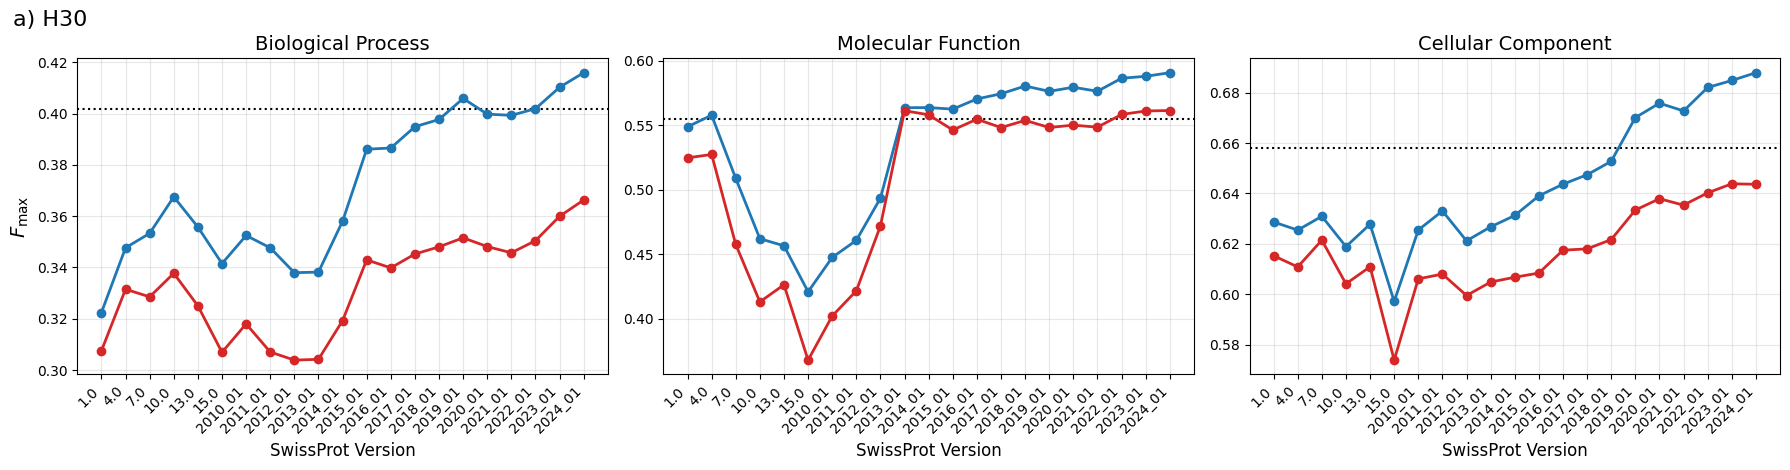

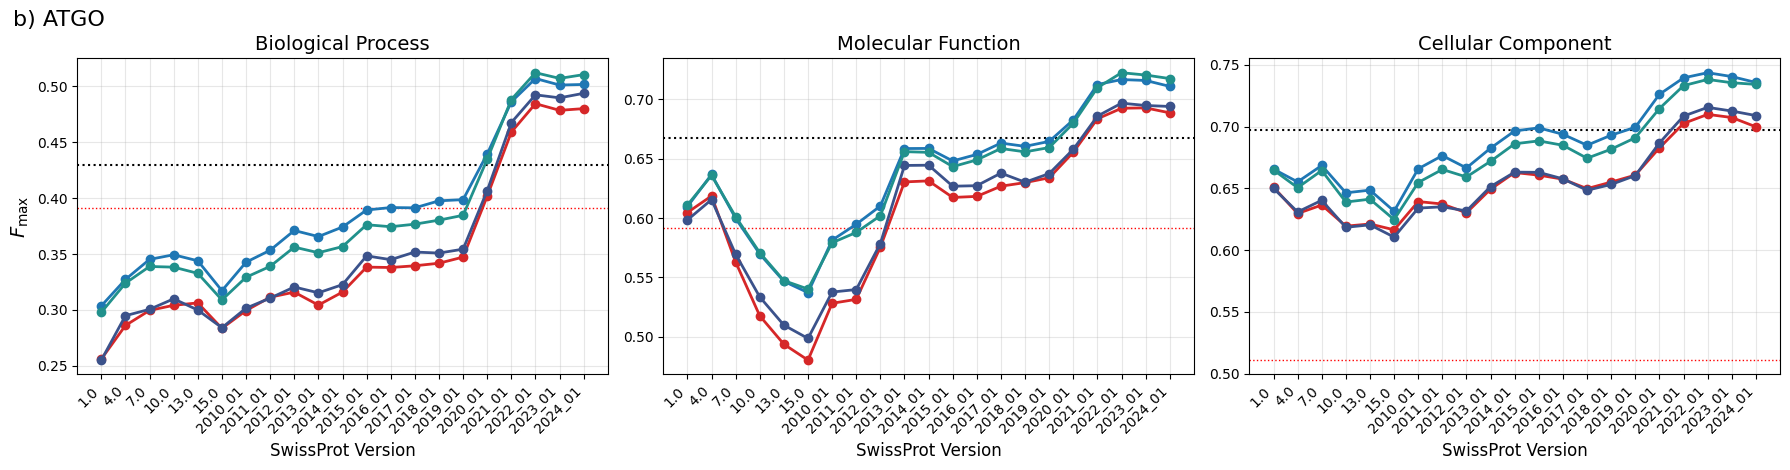

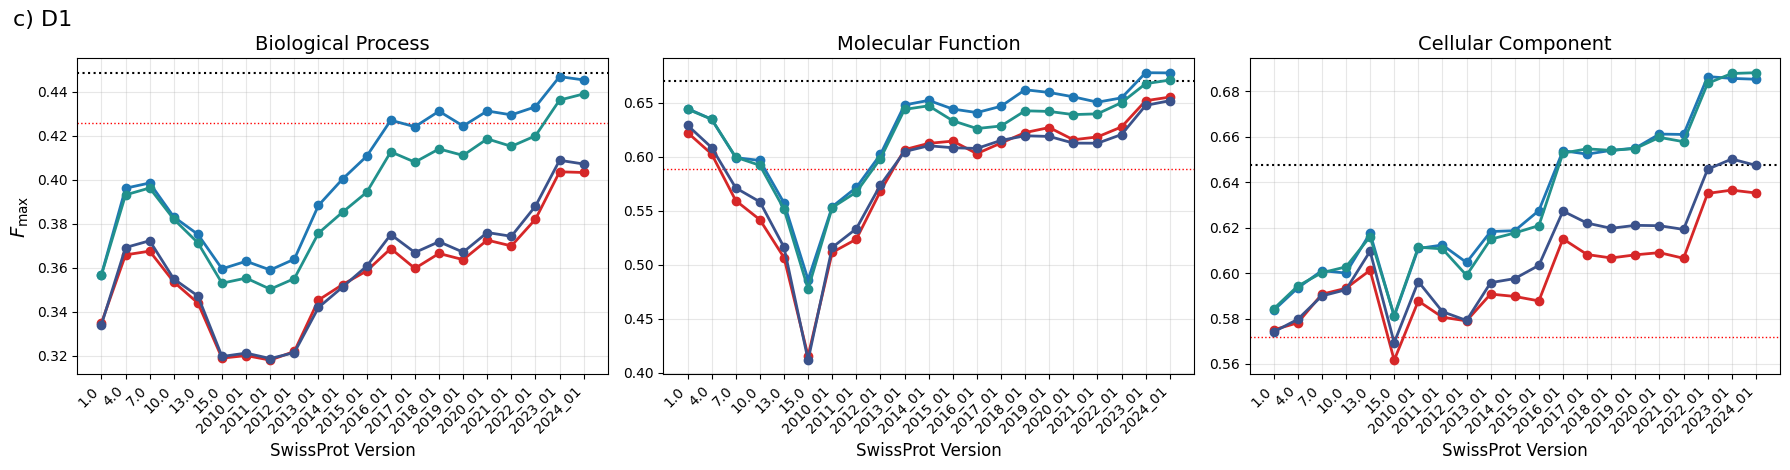

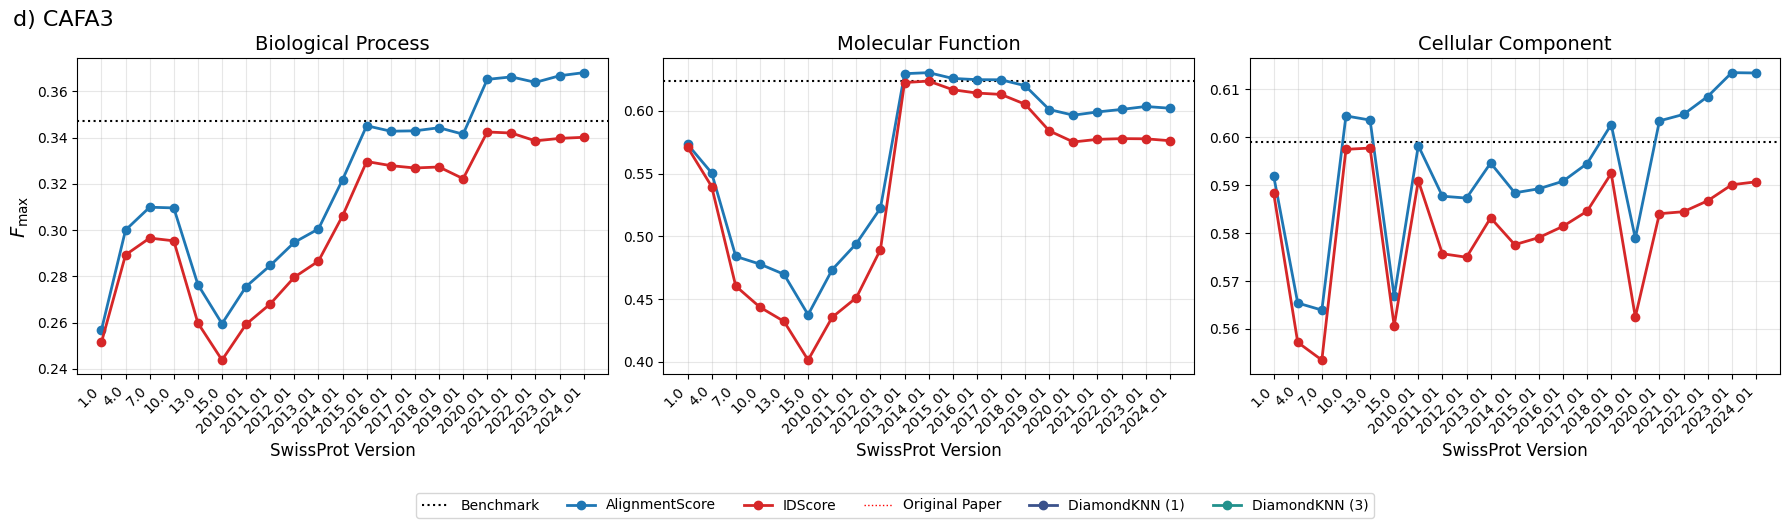

In [ ]:
from matplotlib import cm

blastknn_colors = [cm.viridis(i / 4) for i in range(5)]

conditions = [
    {"onevsall": False, "use_2024_annotations": False, "method": "AlignmentScore", "label": "AlignmentScore", "experimental_only": True, "color": "tab:blue", "marker": "o", "linestyle": '-'},
    {"onevsall": False, "use_2024_annotations": False, "method": "IDScore", "label": "IDScore", "experimental_only": True, "color": "tab:red", "marker": "o", "linestyle": '-'},
    {"onevsall": False, "use_2024_annotations": False, "method": "BlastKNN", "k": 1,  "label": "DiamondKNN (1)",  "experimental_only": True, "color": blastknn_colors[1], "marker": "o", "linestyle": '-'},
    {"onevsall": False, "use_2024_annotations": False, "method": "BlastKNN", "k": 3,  "label": "DiamondKNN (3)",  "experimental_only": True, "color": blastknn_colors[2], "marker": "o", "linestyle": '-'},
    # {"onevsall": False, "use_2024_annotations": False, "method": "BlastKNN", "k": 5,  "label": "BlastKNN (5)",  "experimental_only": True, "color": blastknn_colors[2], "marker": "o", "linestyle": '-'},
    # {"onevsall": False, "use_2024_annotations": False, "method": "BlastKNN", "k": 10, "label": "BlastKNN (10)", "experimental_only": True, "color": blastknn_colors[3], "marker": "o", "linestyle": '-'},
    # {"onevsall": False, "use_2024_annotations": False, "method": "BlastKNN", "k": 15, "label": "BlastKNN (15)", "experimental_only": True, "color": blastknn_colors[4], "marker": "o", "linestyle": '-'},
    # {"onevsall": False, "use_2024_annotations": False, "method": "BlastKNN", "k": 20, "label": "BlastKNN (20)", "experimental_only": True, "color": blastknn_colors[5], "marker": "o", "linestyle": '-'},
        # {"onevsall": False, "use_2024_annotations": False, "method": "NaiveBaseline", "label": "NaiveBaseline", "experimental_only": True, "color": blastknn_colors[3], "marker": "o", "linestyle": '-'},
]
plot_metric_evolution(DATASETS, metric='result_fmax', coverage=False, conditions=conditions)
# plot_metric_evolution(DATASETS, metric='result_aupr', coverage=False, conditions=conditions)
# plot_metric_evolution(DATASETS, metric='result_icaupr', coverage=False, conditions=conditions)
# plot_metric_evolution(DATASETS, metric='result_smin', coverage=False, conditions=conditions)


### Curated vs Non-curated Annotations

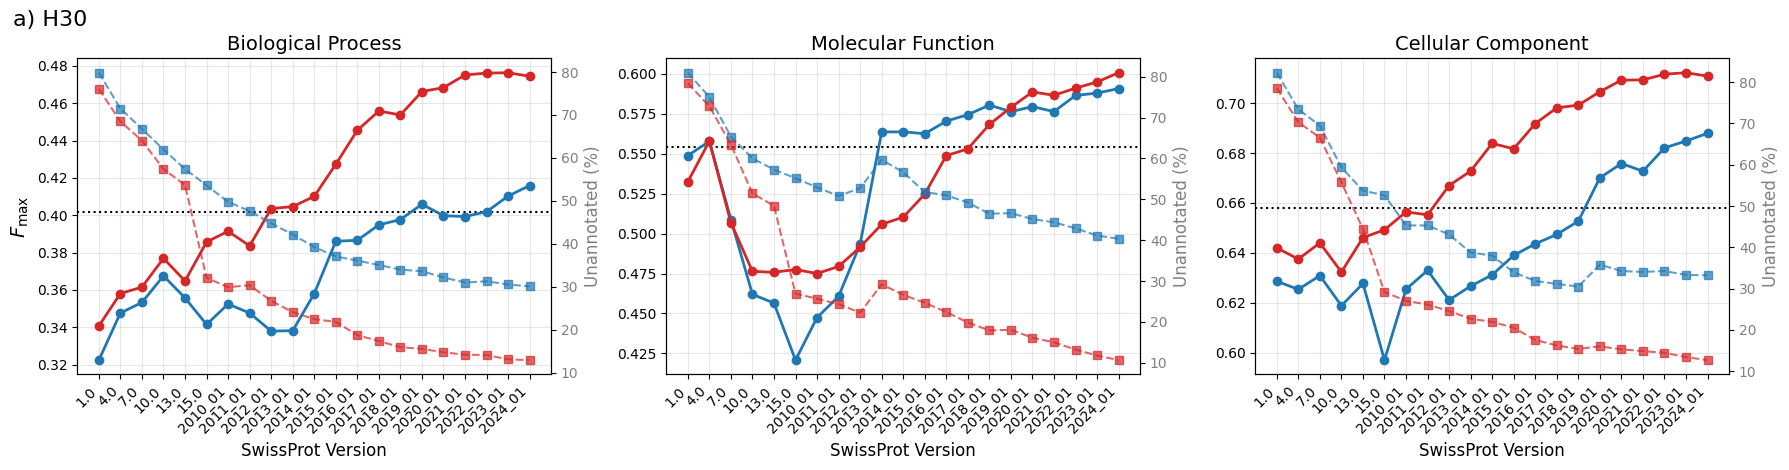

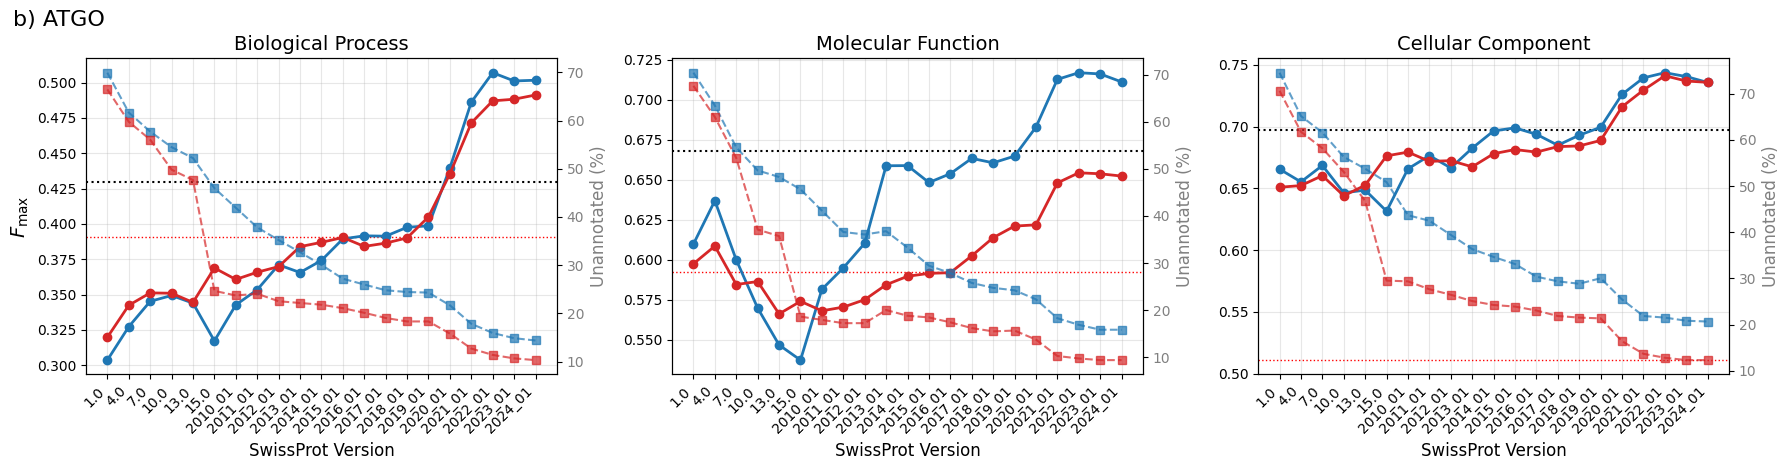

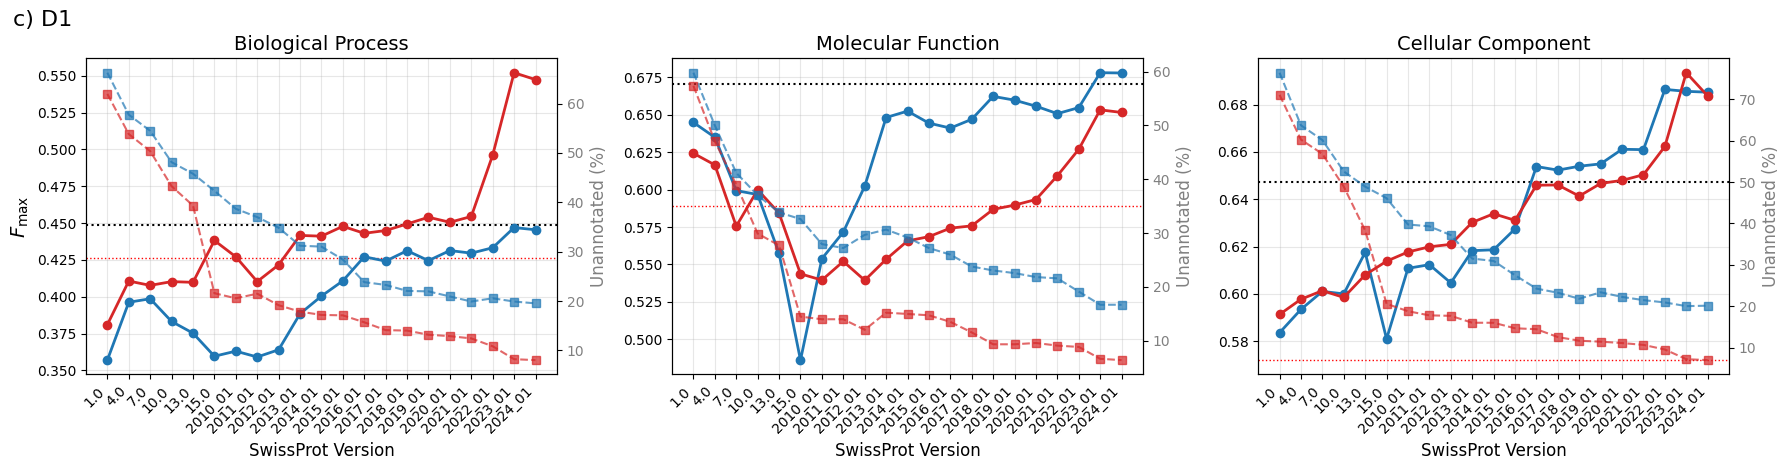

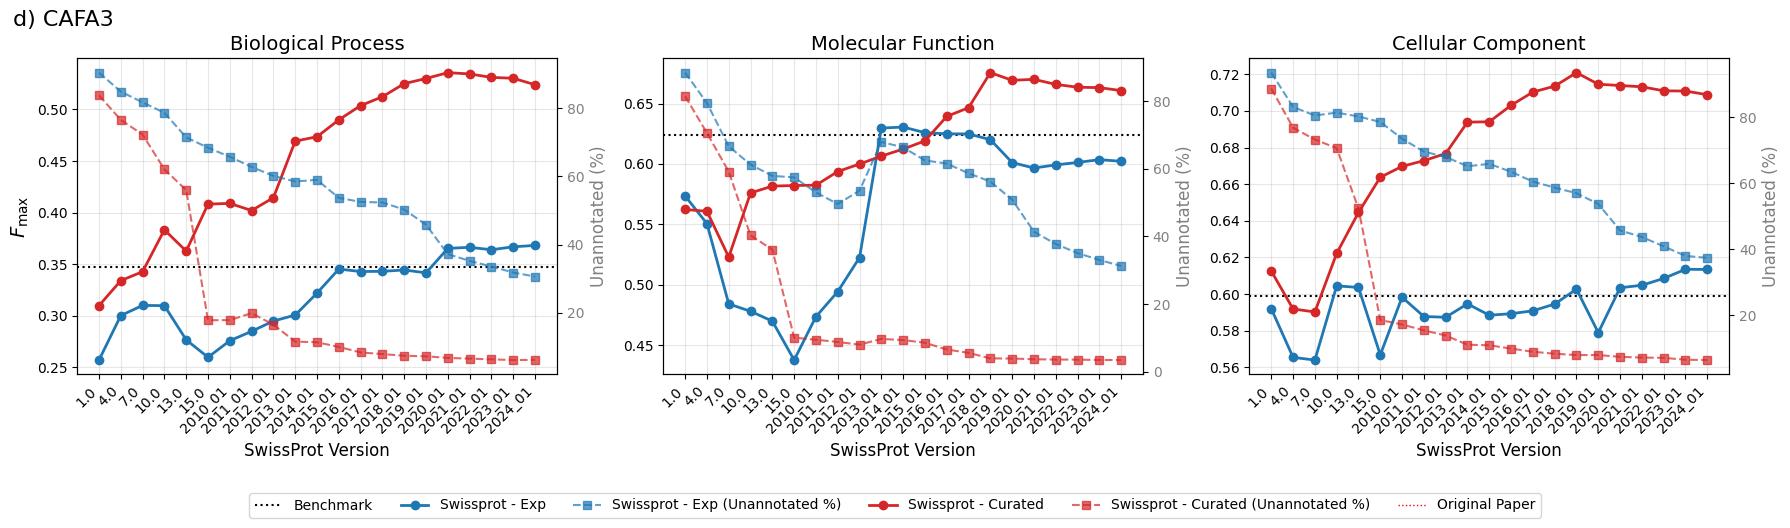

In [6]:
conditions = [
    {"onevsall": False, "use_2024_annotations": False, "method": "AlignmentScore", "label": "Swissprot - Exp", "experimental_only": True, "color": "tab:blue", "marker": "o", "linestyle": '-'},
    {"onevsall": False, "use_2024_annotations": False, "method": "AlignmentScore", "label": "Swissprot - Curated", "experimental_only": False, "color": "tab:red", "marker": "o", "linestyle": '-'},
]
plot_metric_evolution(DATASETS, metric='result_fmax', coverage=True, conditions=conditions)
# plot_metric_evolution(DATASETS, metric='result_aupr', coverage=True, conditions=conditions)
# plot_metric_evolution(DATASETS, metric='result_smin', coverage=True, conditions=conditions)
# plot_metric_evolution(DATASETS, metric='result_icaupr', coverage=True, conditions=conditions)


### Condition Comparison

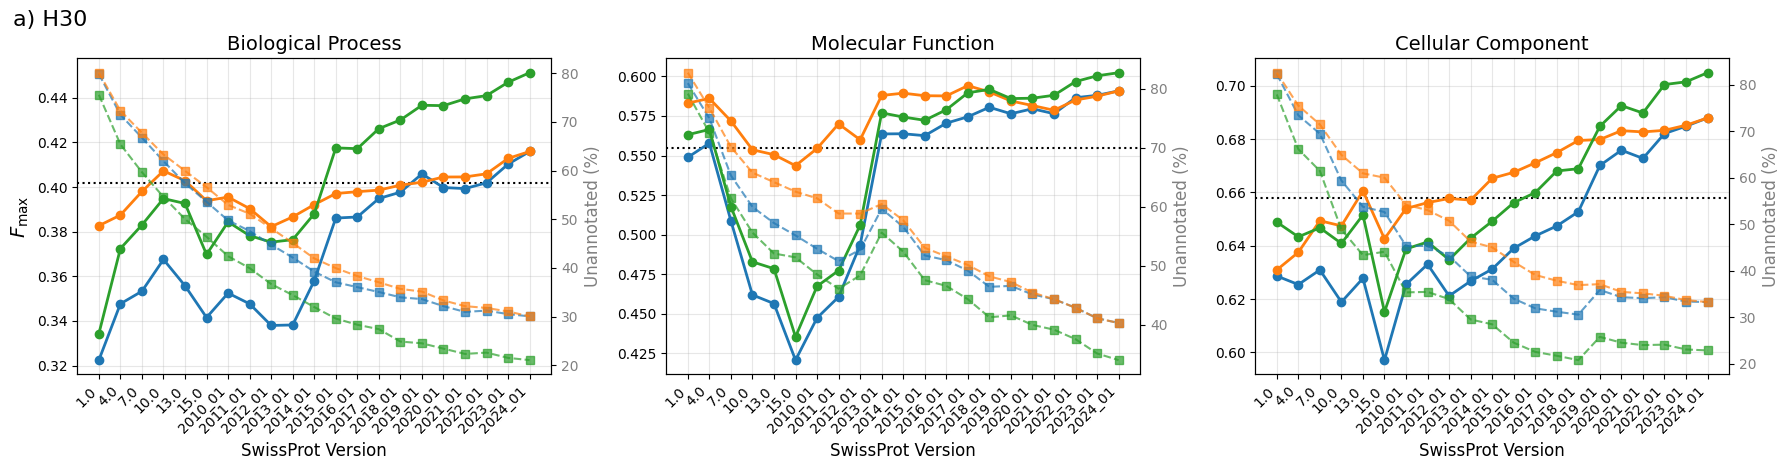

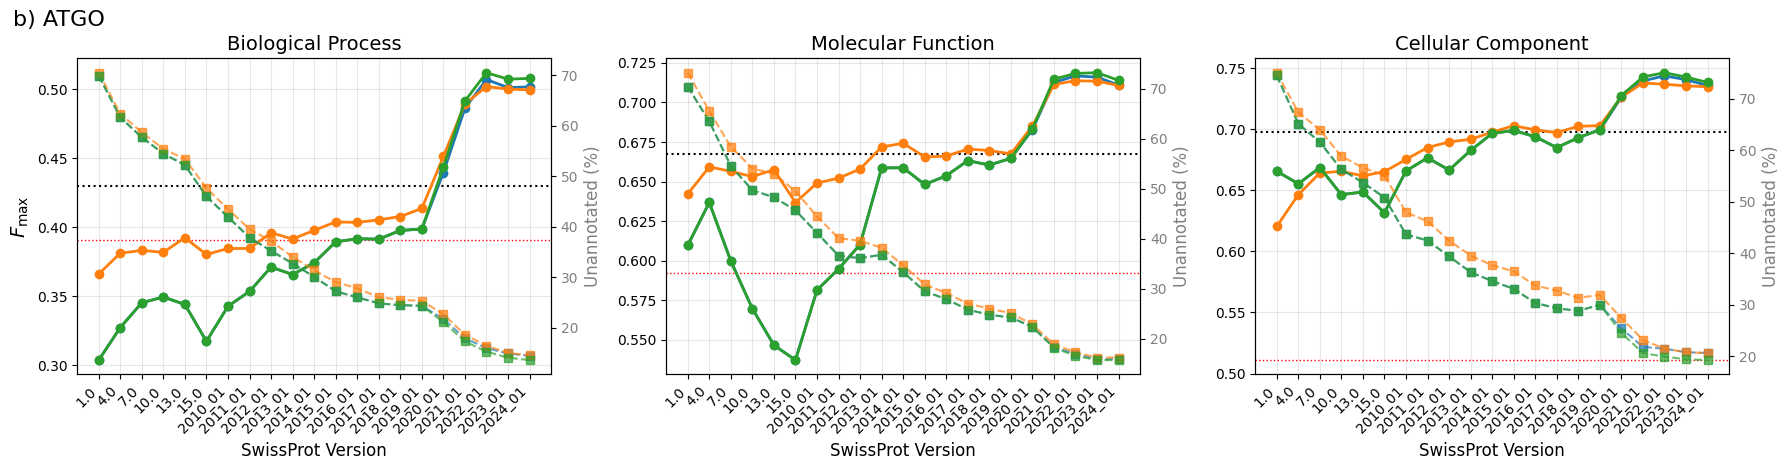

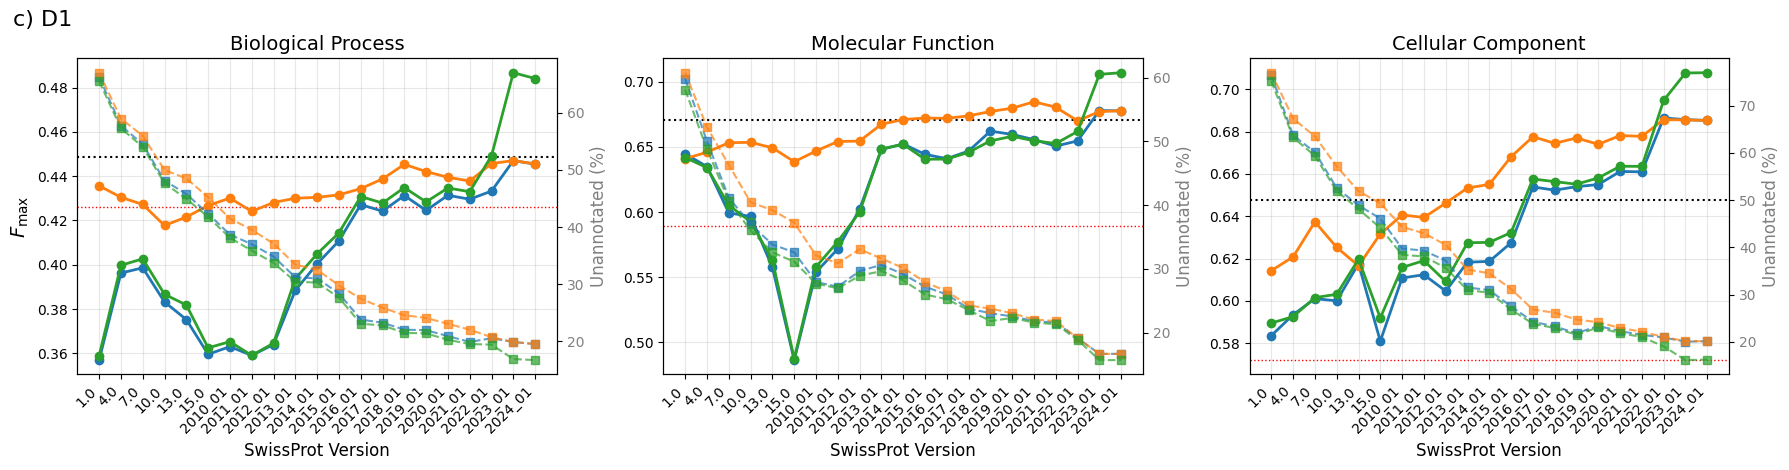

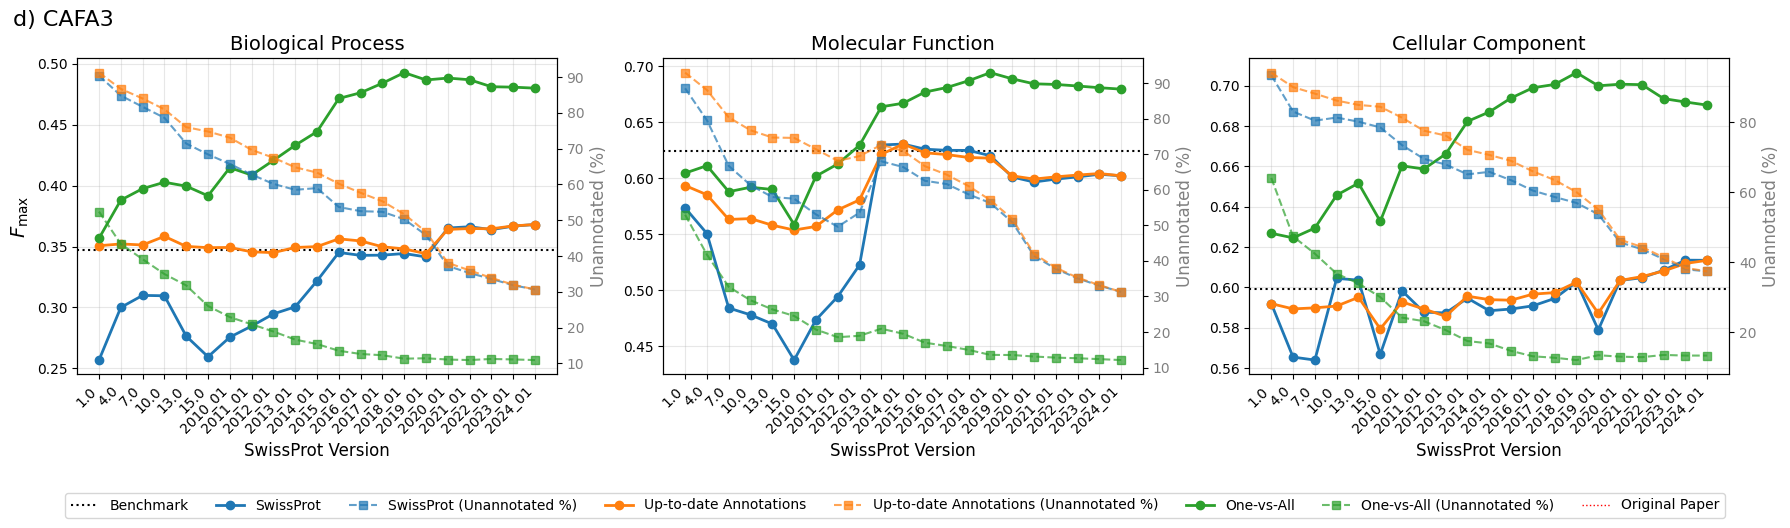

In [8]:
conditions = [
    {"onevsall": False, "use_2024_annotations": False, "experimental_only": True, "method": "AlignmentScore", "label": "SwissProt", "color": "tab:blue", "marker": "o", "linestyle": '-'},
    {"onevsall": False, "use_2024_annotations": True, "experimental_only": True, "method": "AlignmentScore", "label": "Up-to-date Annotations", "color": "tab:orange", "marker": "o", "linestyle": '-'},
    {"onevsall": True, "use_2024_annotations": False, "experimental_only": True, "method": "AlignmentScore", "label": "One-vs-All", "color": "tab:green", "marker": "o", "linestyle": '-'},

]
plot_metric_evolution(DATASETS, metric='result_fmax', coverage=True, conditions=conditions)
# plot_metric_evolution(DATASETS, metric='result_aupr', coverage=True, conditions=conditions)
# plot_metric_evolution(DATASETS, metric='result_icaupr', coverage=True, conditions=conditions)
# plot_metric_evolution(DATASETS, metric='result_smin', coverage=True, conditions=conditions)

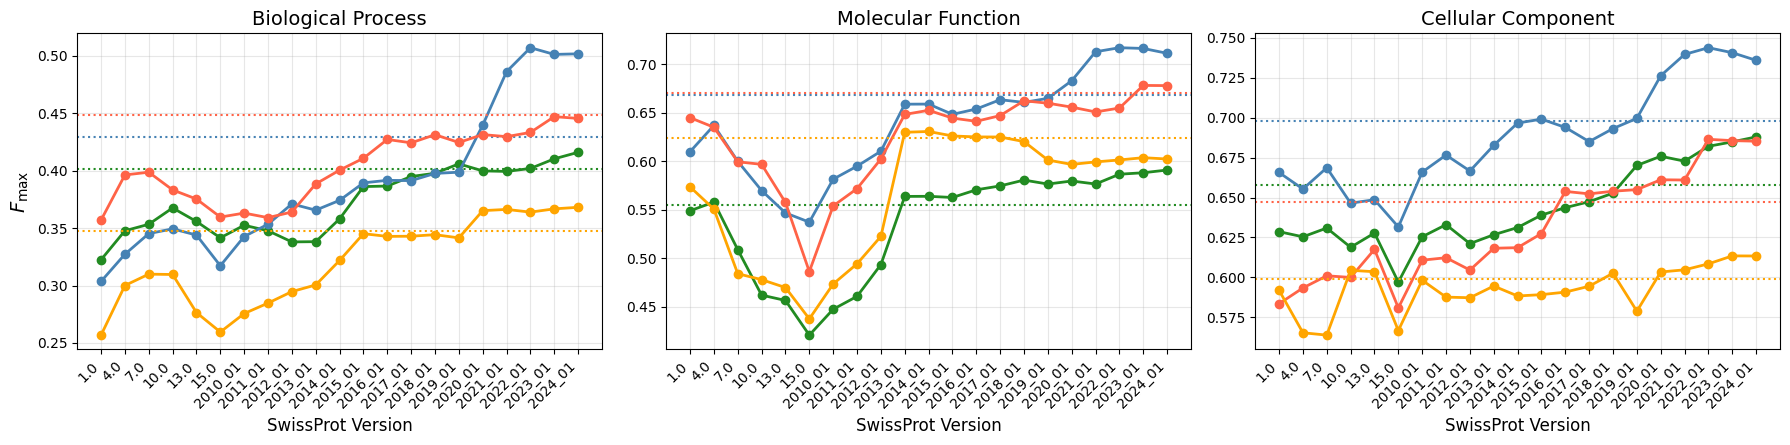

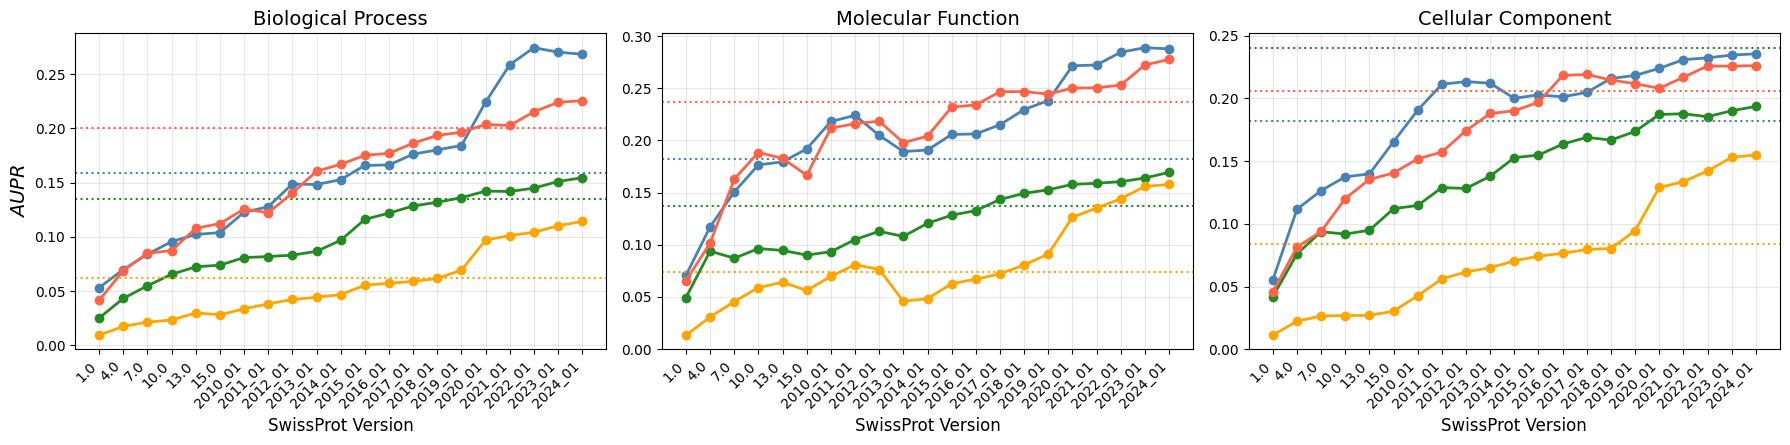

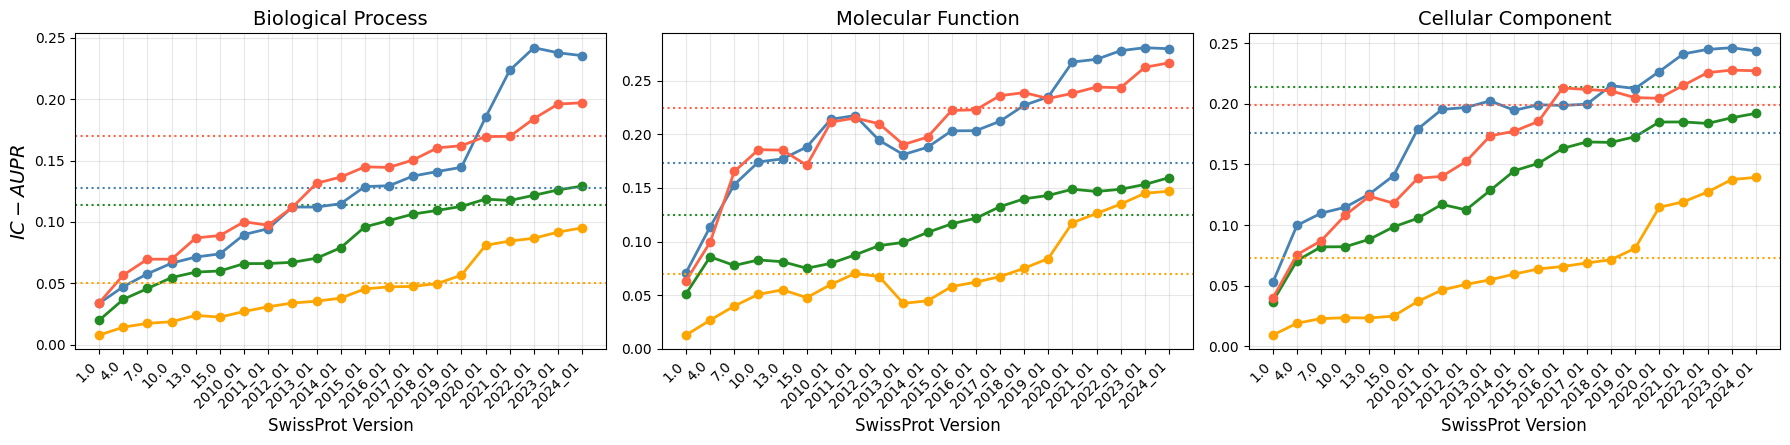

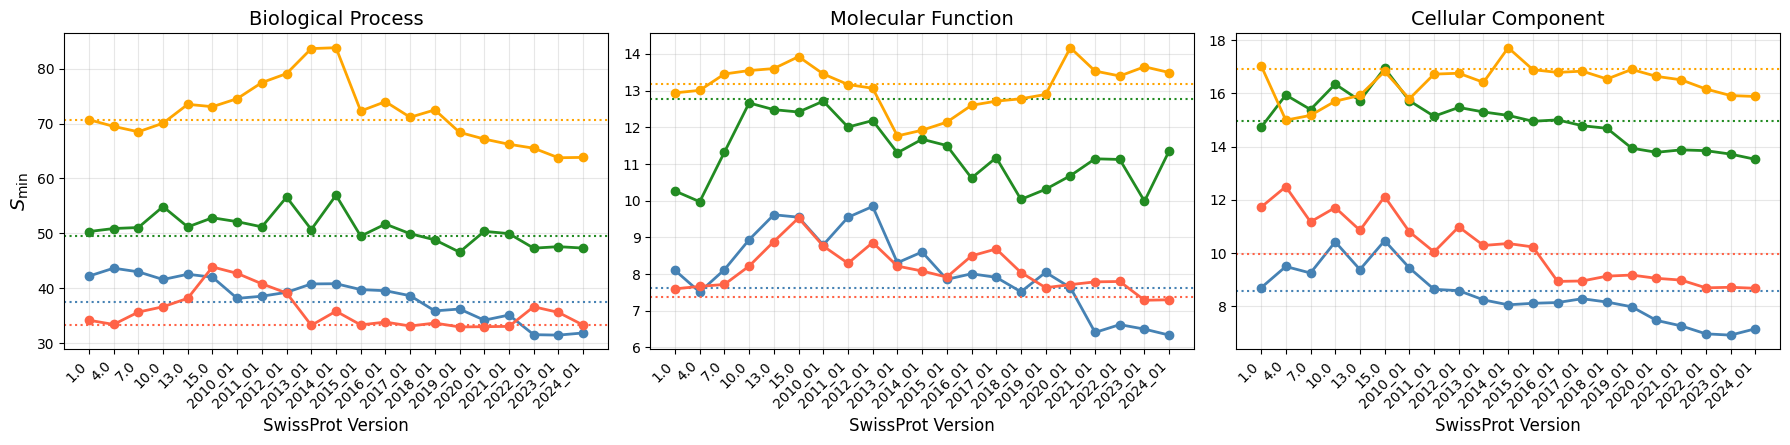

In [7]:
def plot_metric_evolution_by_dataset(
    datasets,
    metric='result_fmax',
    coverage=False,
    condition=None
):
    """
    Create plots showing metric evolution across SwissProt versions with one curve per dataset.
    Each subplot represents a subontology, and each curve represents a dataset.
    
    Args:
        datasets: List of dataset names
        metric: Metric to plot (e.g., 'result_fmax', 'result_aupr', etc.)
        coverage: Whether to show coverage information on secondary y-axis
        condition: Single condition dictionary specifying method parameters
    """
    metric_name = {
        'result_fmax': r'$F_{\max}$',
        'result_smin': r'$S_{\min}$',
        'result_aupr': r'$AUPR$',
        'result_icaupr': r'$IC-AUPR$',
        'result_dpaupr': r'$DP-AUPR$'
    }
    
    # Dataset colors
    dataset_colors = {
        'H30': 'forestgreen',
        'ATGO': 'steelblue', 
        'D1': 'tomato',
        'CAFA3': 'orange'
    }
    
    # Redline values for "Original Paper"
    original_paper_values = {
        "result_fmax": {
            "D1": {"BPO": 0.426, "MFO": 0.589, "CCO": 0.572},
            "ATGO": {"BPO": 0.391, "MFO": 0.592, "CCO": 0.511},
        },
        "result_icaupr": {
            "D1": {"BPO": 0.165, "MFO": 0.360, "CCO": 0.229},
        },
        "result_aupr": {
            "D1": {"BPO": 0.195, "MFO": 0.384, "CCO": 0.281},
            "ATGO": {"BPO": 0.209, "MFO": 0.272, "CCO": 0.239},
        },
        "result_dpaupr": {
            "D1": {"BPO": 0.154, "MFO": 0.345, "CCO": 0.227},
        },
        "result_smin": {
            "D1": {"BPO": 31.502, "MFO": 8.303, "CCO": 11.548},
        },
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    all_handles = []
    all_labels = []
    
    for i, subontology in enumerate(SUBONTOLOGIES):
        ax = axes[i]
        if coverage:
            ax2 = ax.twinx()
        
        # # Plot thin red hline for "Original Paper" if available for this metric
        # for dataset in datasets:
        #     if (metric in original_paper_values and 
        #         dataset in original_paper_values[metric] and 
        #         subontology in original_paper_values[metric][dataset]):
        #         red_value = original_paper_values[metric][dataset][subontology]
        #         redline = ax.axhline(red_value, color='red', linestyle=':', linewidth=1, alpha=0.7)
        #         if i == 0 and dataset == datasets[0]:  # Only add the Original Paper line once
        #             all_handles.append(redline)
        #             all_labels.append('Original Paper')
        
        for dataset in datasets:
            color = dataset_colors.get(dataset, 'black')
            
            metric_scores = []
            unannotated_percentages = []
            valid_versions = []
            
            # --- Compute Benchmark value ---
            try:
                benchmark_exp_results = load_evaluation_results(
                    dataset, subontology, '', method=condition["method"],
                    use_2024_annotations=condition["use_2024_annotations"],
                    onevsall=condition["onevsall"], 
                    experimental_only=condition["experimental_only"],
                    k=condition.get("k", None)
                )
                benchmark_exp_value = benchmark_exp_results.get(metric, np.nan)
            except Exception:
                print(f"Warning: Could not load benchmark for {dataset} {subontology}")
                benchmark_exp_value = np.nan
            
            # Plot thin dotted hline to show Benchmark perf
            if not np.isnan(benchmark_exp_value):
                hline = ax.axhline(benchmark_exp_value, color=color, linestyle=':', linewidth=1.5, alpha=1)
                if i == 0:  # Only add the Benchmark line once per dataset
                    all_handles.append(hline)
                    all_labels.append(f'{dataset} Benchmark')
            
            for version in SWISSPROT_VERSIONS:
                try:
                    if coverage:
                        results, unannotated = load_evaluation_results(
                            dataset, subontology, version, method=condition["method"],
                            use_2024_annotations=condition["use_2024_annotations"],
                            onevsall=condition["onevsall"],
                            return_unannotated=True,
                            experimental_only=condition["experimental_only"],
                            k=condition.get("k", None)
                        )
                        gt = load_ground_truth(dataset, subontology, experimental_only=condition["experimental_only"])
                        total_proteins = len(gt['EntryID'].unique())
                        unannotated_pct = (len(unannotated) / total_proteins) * 100 if total_proteins > 0 else 0
                    else:
                        results = load_evaluation_results(
                            dataset, subontology, version, method=condition["method"],
                            use_2024_annotations=condition["use_2024_annotations"],
                            onevsall=condition["onevsall"],
                            experimental_only=condition["experimental_only"],
                            k=condition.get("k", None)
                        )
                        unannotated_pct = None
                    
                    metric_value = results.get(metric, np.nan)
                    if not np.isnan(metric_value):
                        metric_scores.append(metric_value)
                        valid_versions.append(version)
                        if coverage:
                            unannotated_percentages.append(unannotated_pct)
                except FileNotFoundError:
                    continue
            
            if metric_scores:
                (line,) = ax.plot(valid_versions, metric_scores, marker=condition.get("marker", "o"),
                                  label=dataset, color=color, linestyle=condition.get("linestyle", "-"), linewidth=2)
                if i == 0:
                    all_handles.append(line)
                    all_labels.append(dataset)
                
                # Plot coverage if requested
                if coverage and unannotated_percentages:
                    (line2,) = ax2.plot(valid_versions, unannotated_percentages, marker='s',
                                        alpha=0.7, color=color, linestyle='--', label=f"{dataset} (Unannotated %)")
                    if i == 0:
                        all_handles.append(line2)
                        all_labels.append(f"{dataset} (Unannotated %)")
        
        ax.set_title(SUBONTOLOGIES_LABELS[subontology], fontsize=14)
        ax.set_xlabel("SwissProt Version", fontsize=12)
        if i == 0:
            ax.set_ylabel(metric_name[metric], fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        ax.set_xticks(range(len(SWISSPROT_VERSIONS)))
        ax.set_xticklabels(SWISSPROT_VERSIONS, rotation=45, ha='right')
        
        if coverage:
            ax2.set_ylabel("Unannotated (%)", fontsize=12, color='gray')
            ax2.tick_params(axis='y', labelcolor='gray')
            ax2.set_xticks(range(len(SWISSPROT_VERSIONS)))
            ax2.set_xticklabels(SWISSPROT_VERSIONS, rotation=45, ha='right')
    
    # title_suffix = " with Coverage" if coverage else ""
    # condition_label = condition.get("label", condition.get("method", ""))
    # fig.suptitle(f"{condition_label}{title_suffix}", fontsize=16)
    # fig.legend(
    #     all_handles,
    #     all_labels,
    #     loc='lower center',
    #     ncol=len(all_labels),
    #     bbox_to_anchor=(0.5, -0.05)
    # )
    plt.tight_layout(rect=[0, 0.05, 1, 0.96])
    plt.show()

condition = {"onevsall": False, "use_2024_annotations": False, "experimental_only": True, "method": "AlignmentScore", "label": "SwissProt", "color": "tab:blue", "marker": "o", "linestyle": '-'}
plot_metric_evolution_by_dataset(DATASETS, metric='result_fmax', coverage=False, condition=condition)
plot_metric_evolution_by_dataset(DATASETS, metric='result_aupr', coverage=False, condition=condition)
plot_metric_evolution_by_dataset(DATASETS, metric='result_icaupr', coverage=False, condition=condition)
plot_metric_evolution_by_dataset(DATASETS, metric='result_smin', coverage=False, condition=condition)


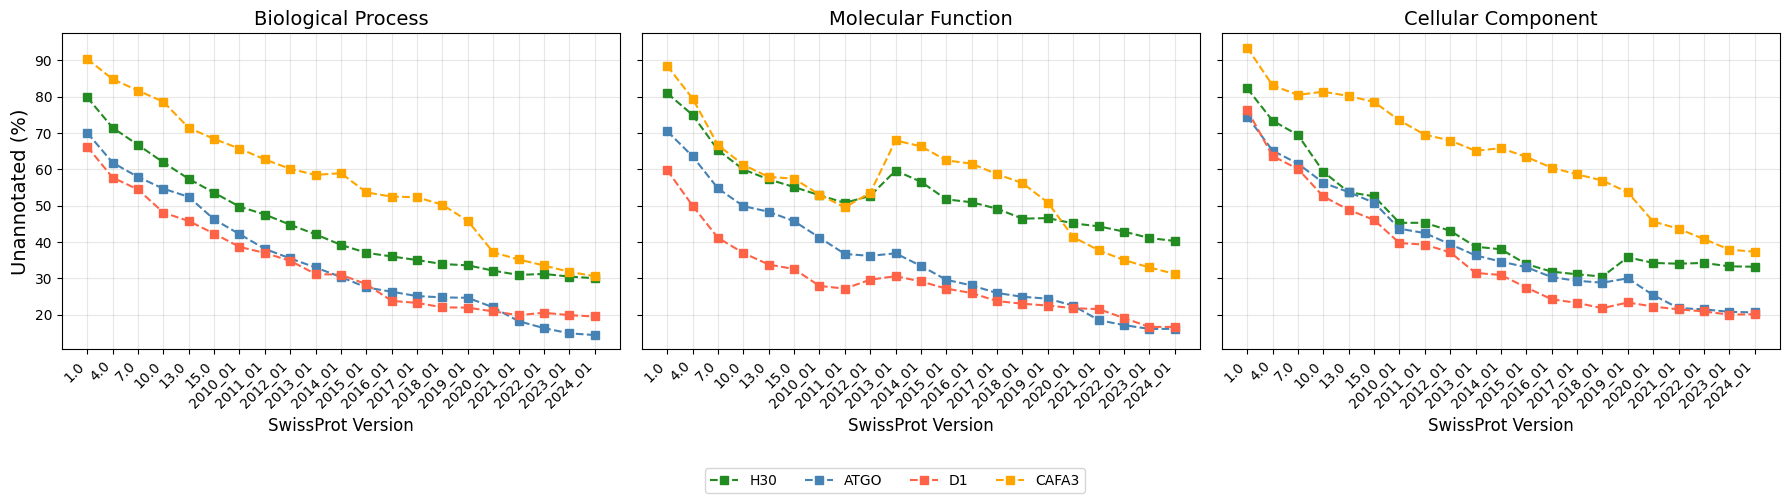

In [ ]:
def plot_coverage_evolution_by_dataset(datasets, subontologies, swissprot_versions, method="AlignmentScore", onevsall=False, use_2024_annotations=False, experimental_only=True):
    """
    Plot the evolution of unannotated protein coverage (percentage) over SwissProt versions.
    Each subplot represents a subontology, each curve a dataset.
    """

    dataset_colors = {
        'H30': 'forestgreen',
        'ATGO': 'steelblue', 
        'D1': 'tomato',
        'CAFA3': 'orange'
    }

    fig, axes = plt.subplots(1, len(subontologies), figsize=(18, 5), sharey=True)
    # fig.text(0.01, 0.98, 'b)', fontsize=16, va='top', ha='left')

    all_handles = []
    all_labels = []

    for idx, subontology in enumerate(subontologies):
        ax = axes[idx]
        for dataset in datasets:
            color = dataset_colors.get(dataset, 'black')
            unannotated_percentages = []
            valid_versions = []
            for version in swissprot_versions:
                try:
                    # Load unannotated set from evaluation results
                    _, unannotated = load_evaluation_results(
                        dataset, subontology, version,
                        method=method,
                        use_2024_annotations=use_2024_annotations,
                        onevsall=onevsall,
                        return_unannotated=True,
                        experimental_only=experimental_only
                    )
                    gt = load_ground_truth(dataset, subontology, version=version, experimental_only=experimental_only)
                    total_proteins = len(gt['EntryID'].unique())
                    unannotated_pct = (len(unannotated) / total_proteins) * 100 if total_proteins > 0 else 0
                    unannotated_percentages.append(unannotated_pct)
                    valid_versions.append(version)
                except Exception:
                    unannotated_percentages.append(np.nan)
                    valid_versions.append(version)
            (line,) = ax.plot(valid_versions, unannotated_percentages, marker='s', linestyle='--', color=color, label=dataset)
            if idx == 0:
                all_handles.append(line)
                all_labels.append(dataset)
        ax.set_title(SUBONTOLOGIES_LABELS[subontology], fontsize=14)
        ax.set_xlabel("SwissProt Version", fontsize=12)
        if idx == 0:
            ax.set_ylabel("Unannotated (%)", fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        ax.set_xticks(range(len(swissprot_versions)))
        ax.set_xticklabels(swissprot_versions, rotation=45, ha='right')

    # fig.suptitle("Coverage Evolution (Unannotated %) by Dataset", fontsize=16)
    fig.legend(all_handles, all_labels, loc='lower center', ncol=len(all_handles), bbox_to_anchor=(0.5, -0.05))
    plt.tight_layout(rect=[0, 0.05, 1, 0.96])
    plt.show()

plot_coverage_evolution_by_dataset(DATASETS, SUBONTOLOGIES, SWISSPROT_VERSIONS)

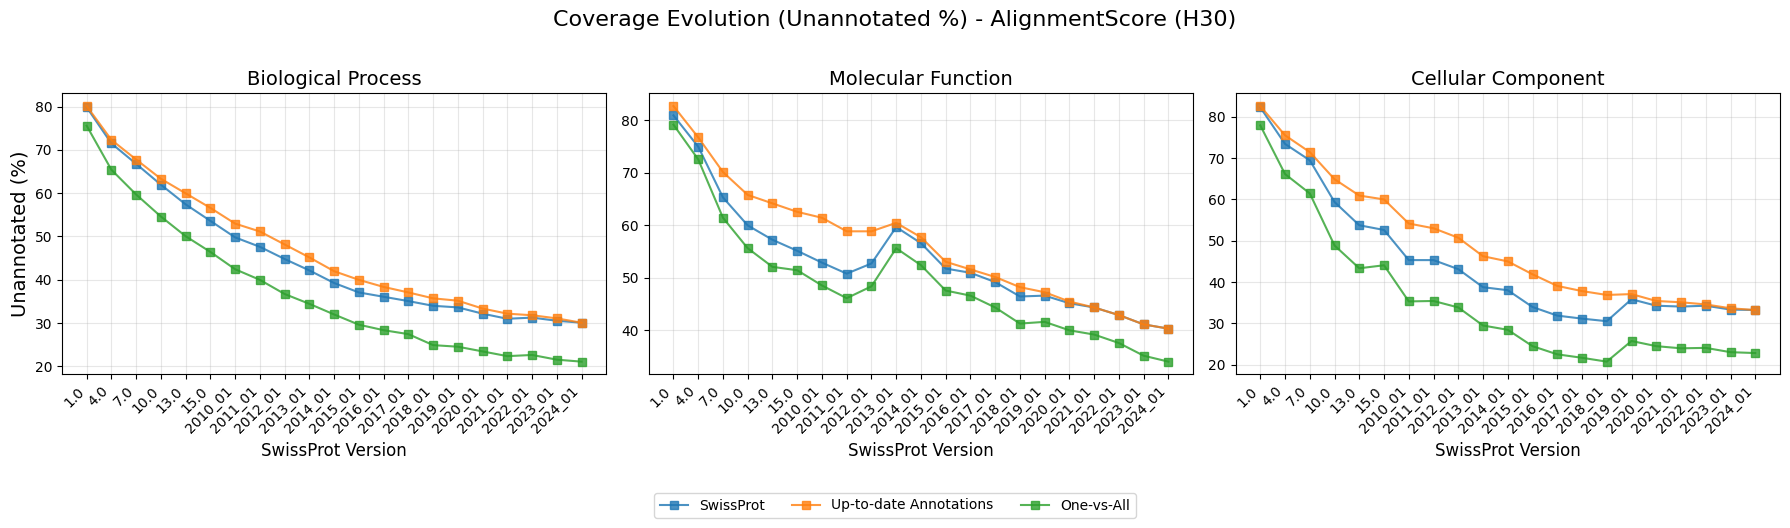

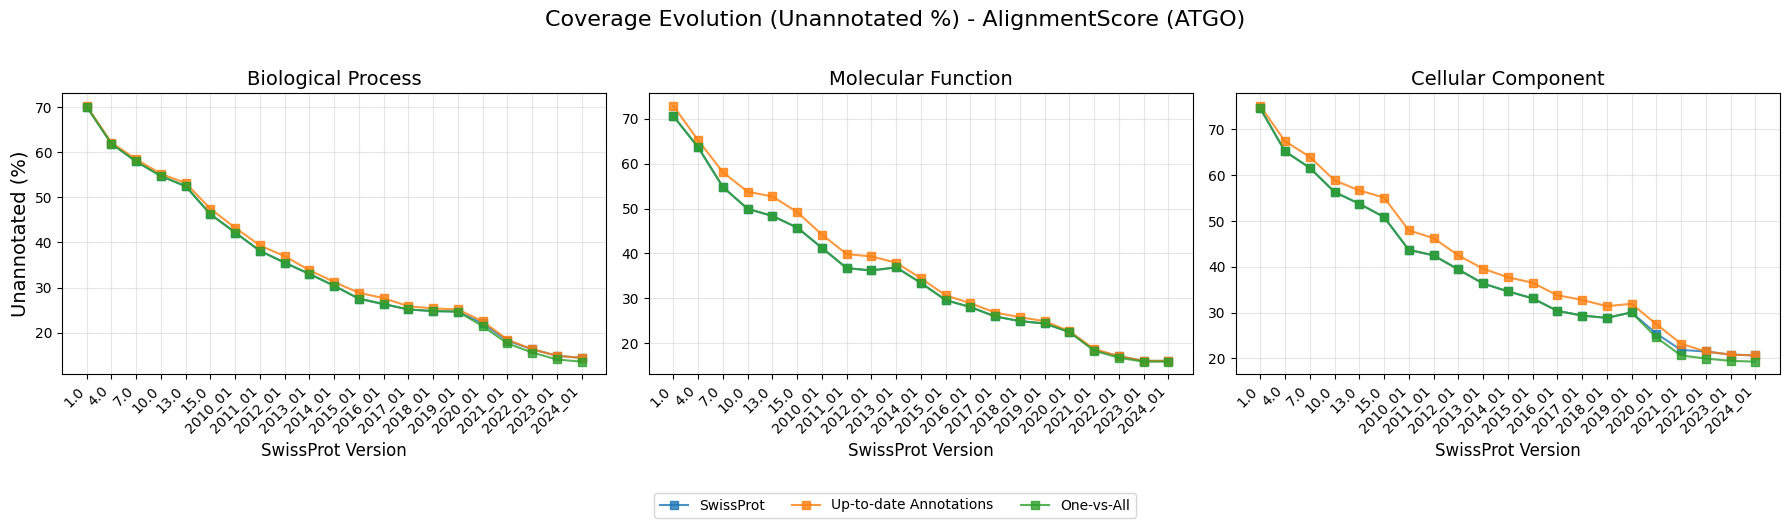

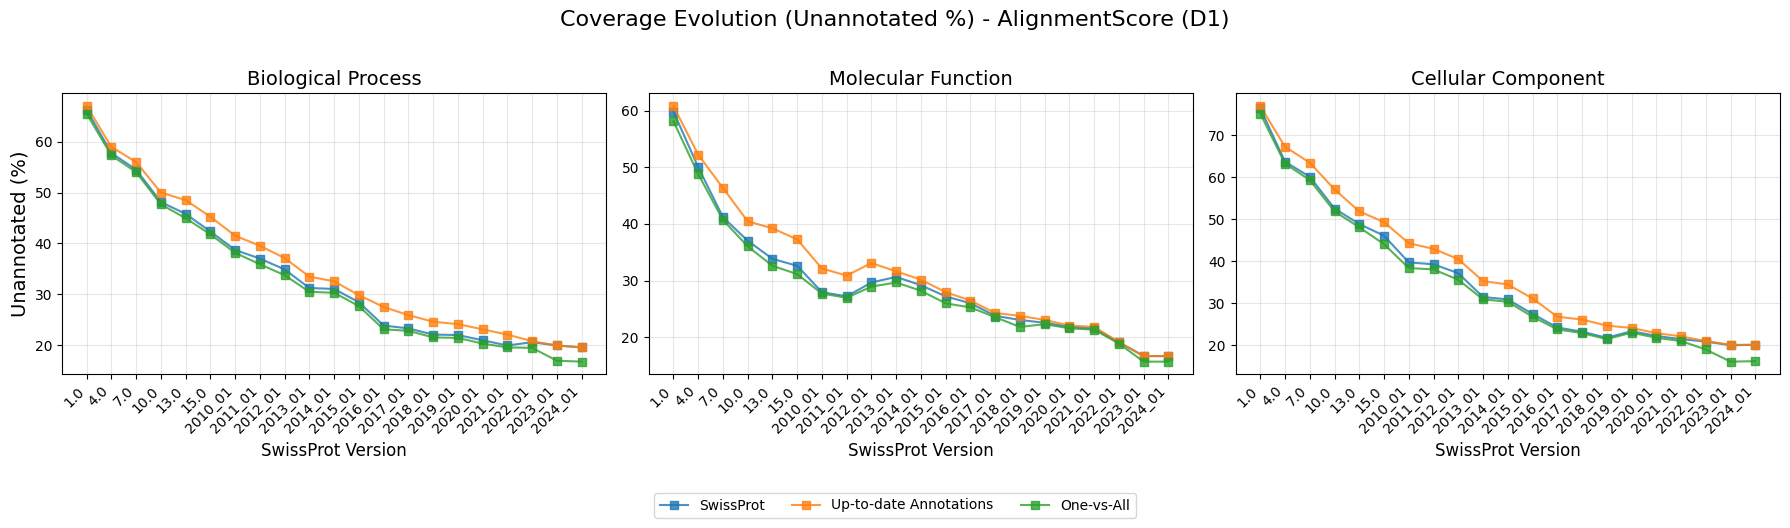

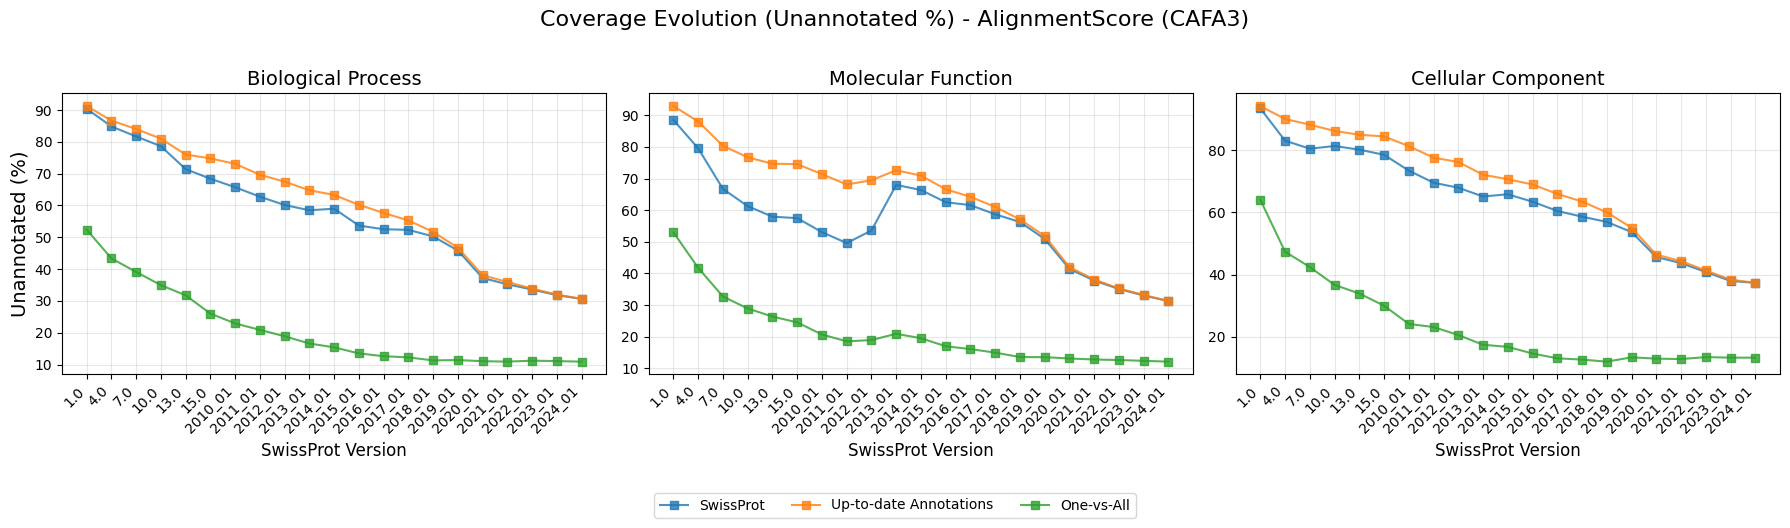

In [ ]:
def plot_coverage_evolution(datasets, method="AlignmentScore", experimental_only=True):
    """
    Plot the evolution of unannotated protein coverage (percentage) over SwissProt versions.
    """
    comparison_sets = [
        {
            "title": "Coverage Evolution (Unannotated %)",
            "conditions": [
                {"onevsall": False, "use_2024_annotations": False, "label": "SwissProt", "color": "tab:blue"},
                {"onevsall": False, "use_2024_annotations": True, "label": "Up-to-date Annotations", "color": "tab:orange"},
                {"onevsall": True, "use_2024_annotations": False, "label": "One-vs-All", "color": "tab:green"},
                # {"onevsall": True, "use_2024_annotations": True, "label": "One-vs-All + Up-to-date", "color": "tab:red"}
            ]
        }
    ]
    for dataset in datasets:
        for comparison in comparison_sets:
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            all_handles = []
            all_labels = []
            for i, subontology in enumerate(SUBONTOLOGIES):
                ax = axes[i]
                for condition in comparison["conditions"]:
                    unannotated_percentages = []
                    valid_versions = []
                    for version in SWISSPROT_VERSIONS:
                        try:
                            _, unannotated = load_evaluation_results(
                                dataset, subontology, version, method=method,
                                use_2024_annotations=condition["use_2024_annotations"],
                                onevsall=condition["onevsall"],
                                return_unannotated=True,
                                experimental_only=experimental_only
                            )
                            gt = load_ground_truth(dataset, subontology, experimental_only=experimental_only)
                            total_proteins = len(gt['EntryID'].unique())
                            unannotated_pct = (len(unannotated) / total_proteins) * 100 if total_proteins > 0 else 0
                            unannotated_percentages.append(unannotated_pct)
                            valid_versions.append(version)
                        except FileNotFoundError:
                            continue
                    if unannotated_percentages:
                        (line,) = ax.plot(valid_versions, unannotated_percentages, marker='s',
                                          linestyle='-', alpha=0.8, color=condition["color"], label=condition["label"])
                        if i == 0:
                            all_handles.append(line)
                            all_labels.append(condition["label"])
                ax.set_title(SUBONTOLOGIES_LABELS[subontology], fontsize=14)
                ax.set_xlabel("SwissProt Version", fontsize=12)
                if i == 0:
                    ax.set_ylabel("Unannotated (%)", fontsize=14)
                ax.tick_params(axis='x', rotation=45)
                ax.grid(True, alpha=0.3)
                ax.set_xticks(range(len(SWISSPROT_VERSIONS)))
                ax.set_xticklabels(SWISSPROT_VERSIONS, rotation=45, ha='right')
            fig.suptitle(f"{comparison['title']} - {method} ({dataset})", fontsize=16)
            fig.legend(all_handles, all_labels, loc='lower center', ncol=len(all_handles)//2 if len(all_handles) > 4 else len(all_handles), bbox_to_anchor=(0.5, -0.05))
            plt.tight_layout(rect=[0, 0.05, 1, 0.96])
            plt.show()

plot_coverage_evolution(DATASETS, method="AlignmentScore")

## Origin Of Unannotated Proteins


ANALYZING DATASET: ATGO
Loading alignment data for SwissProt ...
Loaded 11985456 alignment pairs

--- Processing ATGO BPO ---
Found 245 unannotated proteins
Results for BPO:
  Total unannotated proteins: 245
  Total test proteins: 835
  Case 1 (No alignment): 81
  Case 2 (Only val/test alignments): 16
  Case 3 (No annotations to transfer): 148
  Verification: 245 == 245

--- Processing ATGO MFO ---
Found 186 unannotated proteins
Results for MFO:
  Total unannotated proteins: 186
  Total test proteins: 574
  Case 1 (No alignment): 44
  Case 2 (Only val/test alignments): 15
  Case 3 (No annotations to transfer): 127
  Verification: 186 == 186

--- Processing ATGO CCO ---
Found 212 unannotated proteins
Results for CCO:
  Total unannotated proteins: 212
  Total test proteins: 586
  Case 1 (No alignment): 66
  Case 2 (Only val/test alignments): 17
  Case 3 (No annotations to transfer): 129
  Verification: 212 == 212
Loading alignment data for SwissProt 2024_01...
Loaded 11985456 alignment 

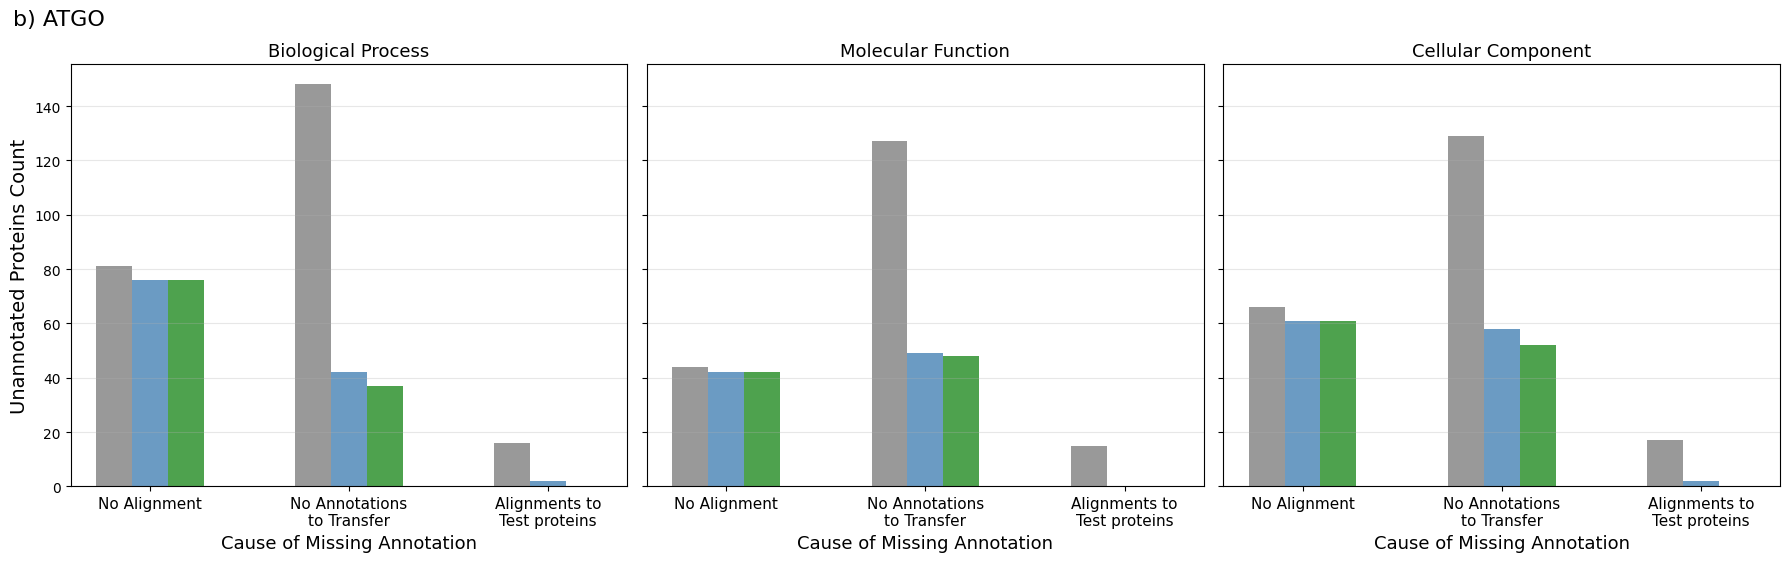

In [ ]:
from dataloading import load_pairwise_alignment, load_uniprot_mapping

def analyze_unannotated_proteins(dataset, swissprot_version="2024_01", suffix=''):
    """
    Analyze why test proteins are unannotated by categorizing them into three cases:
    1. No alignment exists for the protein
    2. Alignments exist but only to proteins in val/test sets (no transfer possible)
    3. Alignments exist to training proteins but no annotations to transfer
    
    Args:
        dataset: Dataset name (e.g., 'ATGO', 'H30', 'D1')
        swissprot_version: SwissProt version to use for alignments
    
    Returns:
        dict: Results for each subontology with counts for each case
    """
    results = {}
    
    # Mapping from SwissProt Entry Name (e.g. Q6GZX1) to EntryID (004R_FRG3G)
    id_mapping = load_uniprot_mapping()

    # Load alignment data once (it's the same for all subontologies)
    print(f"Loading alignment data for SwissProt {swissprot_version}...")
    alignment_df = load_pairwise_alignment(dataset, id_mapping)
    print(f"Loaded {len(alignment_df)} alignment pairs")
    
    # Process each subontology
    for subontology in SUBONTOLOGIES:
        print(f"\n--- Processing {dataset} {subontology} ---")
        
        # Load unannotated proteins list
        unannotated_file = f"./results/{dataset}/baselines_{dataset}_{swissprot_version}_{subontology}{suffix}/unaligned_proteins_{dataset}_{swissprot_version}_{subontology}.txt"
        try:
            with open(unannotated_file, 'r') as f:
                unannotated_proteins = [line.strip() for line in f if line.strip()]
            print(f"Found {len(unannotated_proteins)} unannotated proteins")
        except FileNotFoundError:
            print(f"Unannotated proteins file not found: {unannotated_file}")
            continue
        
        # Load test and validation proteins for this dataset/subontology
        test_file = f"./data/{dataset}/{dataset}_{subontology}_test_annotations.tsv"
        train_file = f"./data/{dataset}/{dataset}_{subontology}_train_annotations.tsv"

        train_df = pd.read_csv(train_file, sep='\t')
        test_df = pd.read_csv(test_file, sep='\t')
        test_proteins = set(test_df['EntryID'].unique())

        # For D1 and CAFA3, we need to consider both val and test sets
        if dataset in ['ATGO']:
            val_file = f"./data/{dataset}/{dataset}_{subontology}_val_annotations.tsv"
            val_df = pd.read_csv(val_file, sep='\t')
            # Merge Train and Val sets to get full training set
            train_df = pd.concat([train_df, val_df])
        
        train_proteins = set(train_df['EntryID'].unique())
        
        # Apply ID mapping to test and validation proteins if dataset in D1
        if dataset in ['D1']:
            test_proteins = {id_mapping.get(protein, protein) for protein in test_proteins}
            train_proteins = {id_mapping.get(protein, protein) for protein in train_proteins}
            unannotated_proteins = {id_mapping.get(protein, protein) for protein in unannotated_proteins}
        unannotated_set = set(unannotated_proteins)

        adf = alignment_df[
            alignment_df['query_id'].isin(test_proteins)
        ]

        if suffix == '':
            adf = alignment_df[
                alignment_df['subject_id'].isin(train_proteins.union(test_proteins))
            ]

        aligned_proteins = set(adf['query_id']).union(set(adf['subject_id']))
        protein_partners = {}
        # Group by query_id and get all subject partners
        query_partners = adf.groupby('query_id')['subject_id'].apply(set).to_dict()
        # Combine both directions
        for protein in aligned_proteins:
            partners = set()
            if protein in query_partners:
                partners.update(query_partners[protein])
            protein_partners[protein] = partners


        # Vectorized categorization
        case1_no_alignment = []
        case2_only_val_test_alignments = []
        case3_no_annotations_to_transfer = []
        
        # Case 1: No alignment (proteins not in alignment data at all)
        proteins_with_no_alignment = unannotated_set - aligned_proteins
        case1_no_alignment = list(proteins_with_no_alignment)
        
        # For proteins with alignments, check cases 2 and 3
        proteins_with_alignments = unannotated_set & aligned_proteins
        
        for protein in proteins_with_alignments:
            partners = protein_partners[protein]
            partners_in_train = partners - test_proteins

            # No partners in training set but has alignments
            if len(partners_in_train) == 0 and protein in query_partners:
                # Case: Only alignments to test proteins
                case2_only_val_test_alignments.append(protein)
            elif protein in test_proteins:
                # Case: Has alignments but still unannotated
                case3_no_annotations_to_transfer.append(protein)

        results[subontology] = {
            'total_unannotated': len(unannotated_proteins),
            'total_test_proteins': len(test_proteins),
            'case1_no_alignment': len(case1_no_alignment),
            'case2_only_val_test': len(case2_only_val_test_alignments),
            'case3_no_annotations': len(case3_no_annotations_to_transfer),
            'case1_proteins': case1_no_alignment,
            'case2_proteins': case2_only_val_test_alignments,
            'case3_proteins': case3_no_annotations_to_transfer
        }
        
        print(f"Results for {subontology}:")
        print(f"  Total unannotated proteins: {len(unannotated_proteins)}")
        print(f"  Total test proteins: {len(test_proteins)}")
        print(f"  Case 1 (No alignment): {len(case1_no_alignment)}")
        print(f"  Case 2 (Only val/test alignments): {len(case2_only_val_test_alignments)}")
        print(f"  Case 3 (No annotations to transfer): {len(case3_no_annotations_to_transfer)}")
        print(f"  Verification: {len(case1_no_alignment) + len(case2_only_val_test_alignments) + len(case3_no_annotations_to_transfer)} == {len(unannotated_proteins)}")
    
    return results

def plot_unannotated_comparison_counts(dataset, results_dict, condition_labels, condition_colors, log_y=False):
    """
    Compare the distribution of unannotated protein causes across multiple conditions,
    with y-axis as raw counts of unannotated proteins.
    Args:
        dataset: Dataset name
        results_dict: dict {condition_name: results_from_analyze_unannotated_proteins}
        condition_labels: dict {condition_name: label_for_legend}
        condition_colors: dict {condition_name: color_for_bars}
        log_y: If True, use log scale for y-axis
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    tag_texts = {'H30': 'a) H30', 'ATGO': 'b) ATGO', 'D1': 'c) D1', 'CAFA3': 'd) CAFA3'}
    categories = ['No Alignment', 'No Annotations\nto Transfer', 'Alignments to\nTest proteins']
    n_conditions = len(results_dict)
    bar_width = 0.18
    x = np.arange(len(categories))

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.text(0.01, 0.98, tag_texts[dataset], fontsize=16, va='top', ha='left')

    for idx, subontology in enumerate(SUBONTOLOGIES):
        ax = axes[idx]
        for i, (cond, results) in enumerate(results_dict.items()):
            if subontology not in results:
                continue
            data = results[subontology]
            counts = [
                data['case1_no_alignment'],
                data['case3_no_annotations'],
                data['case2_only_val_test']
            ]
            print(f"{cond} {subontology}: {counts} out of {data['total_test_proteins']}")
            offset = (i - n_conditions/2) * bar_width + bar_width/2
            bars = ax.bar(x + offset, counts, width=bar_width, alpha=0.8,
                          color=condition_colors[cond], label=condition_labels[cond])
        ax.set_title(f"{SUBONTOLOGIES_LABELS[subontology]}", fontsize=13)
        ax.set_xticks(x)
        ax.set_xticklabels(categories, fontsize=11)
        if idx == 0:
            ax.set_ylabel('Unannotated Proteins Count', fontsize=14)
        ax.set_xlabel('Cause of Missing Annotation', fontsize=13)
        if log_y:
            ax.set_yscale('log')
        ax.grid(True, alpha=0.3, axis='y')
    handles, labels = axes[0].get_legend_handles_labels()
    if dataset == 'CAFA3':
        fig.legend(handles, labels, loc='lower center', ncol=len(condition_labels), bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

os.chdir("/home/atoffano/PFP_baselines")
for dataset in DATASETS:
    print(f"\n{'='*50}")
    print(f"ANALYZING DATASET: {dataset}")
    print(f"{'='*50}")

    results_benchmark = analyze_unannotated_proteins(dataset, swissprot_version='', suffix='')
    results_swissprot = analyze_unannotated_proteins(dataset, swissprot_version='2024_01', suffix='_exp')
    # results_up_to_date = analyze_unannotated_proteins(dataset, swissprot_version='2024_01', suffix='_exp_2024_annotations')
    results_onevsall = analyze_unannotated_proteins(dataset, swissprot_version='2024_01', suffix='_exp_one_vs_all')

    results_dict = {
        'Benchmark': results_benchmark,
        'SwissProt': results_swissprot,
        # 'Up-to-date': results_up_to_date,
        'One-vs-All': results_onevsall,
    }
    condition_labels = {
        'Benchmark': 'Benchmark',
        'SwissProt': 'SwissProt',
        # 'Up-to-date': 'Up-to-date',
        'One-vs-All': 'One-vs-All',
    }
    condition_colors = {
        'Benchmark': 'gray',
        'SwissProt': 'steelblue',
        # 'Up-to-date': 'orange',
        'One-vs-All': 'forestgreen',
    }
    plot_unannotated_comparison_counts(dataset, results_dict, condition_labels, condition_colors, log_y=False)

## Detailed AUPRs

In [14]:
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

def plot_pr_curves_evolution(
    datasets, method="AlignmentScore", metric_type='PR',
    show_fmax=True, show_smin=False, use_2024_annotations=False, onevsall=False
):
    """
    Plot precision-recall, Smin (RU vs MI), or IC-PR curves evolution over SwissProt versions.

    Args:
        datasets: List of dataset names (H30, ATGO, D1)
        method: Method name
        metric_type: 'PR' for precision-recall, 'SMIN' for RU vs MI, 'ICPR' for IC-precision-recall
        show_fmax: Whether to show Fmax points on PR curves
        show_smin: Whether to show Smin points on RU/MI curves
        use_2024_annotations: Whether to use _2024_annotations results
        onevsall: Whether to use one-vs-all results
    """
    cmap = get_cmap("viridis")
    norm = Normalize(vmin=0, vmax=len(SWISSPROT_VERSIONS)-1)

    for dataset in datasets:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        tag_texts = {'H30': 'a) H30', 'ATGO': 'a) ATGO', 'D1': 'c) D1', 'CAFA3': 'd) CAFA3'}
        # fig.text(0.01, 0.98, f"{tag_texts[dataset]} - {'One vs. All' if onevsall else 'SwissProt'}", fontsize=16, va='top', ha='left')
        # fig.text(0.01, 0.98, f"c) {method} - Without Endpoints", fontsize=16, va='top', ha='left')

        for i, subontology in enumerate(SUBONTOLOGIES):
            ax = axes[i]
            for version_idx, version in enumerate(SWISSPROT_VERSIONS):
                try:
                    results = load_evaluation_results(
                        dataset, subontology, version, method=method,
                        use_2024_annotations=use_2024_annotations,
                        onevsall=onevsall
                    )
                    color = cmap(norm(version_idx))

                    if metric_type.upper() == 'PR':
                        precision = results.get('precisions', None)
                        recall = results.get('recalls', None)
                        if precision is not None and recall is not None:
                            ax.plot(recall, precision, color=color, label=version, alpha=0.8, linewidth=2)
                            if show_fmax:
                                fmax = results.get('result_fmax', np.nan)
                                threshold = results.get('result_t', np.nan)
                                if not np.isnan(fmax) and not np.isnan(threshold):
                                    mid_idx = len(precision) // 2
                                    ax.scatter(recall[mid_idx], precision[mid_idx], color=color,
                                               s=50, marker='o', edgecolors='white', linewidth=1, zorder=5)
                    elif metric_type.upper() == 'SMIN':
                        ru = results.get('ru_values', None)
                        mi = results.get('mi_values', None)
                        if ru is not None and mi is not None:
                            ax.plot(ru, mi, color=color, label=version, alpha=0.8, linewidth=2)
                            if show_smin:
                                smin = results.get('result_smin', np.nan)
                                if not np.isnan(smin):
                                    distances = np.sqrt((np.array(ru))**2 + (np.array(mi))**2)
                                    min_idx = np.argmin(distances)
                                    ax.scatter(ru[min_idx], mi[min_idx], color=color,
                                               s=50, marker='s', edgecolors='white', linewidth=1, zorder=5)
                    elif metric_type.upper() == 'ICPR':
                        icprecision = results.get('icprecisions', None)
                        icrecall = results.get('icrecalls', None)
                        if icprecision is not None and icrecall is not None:
                            ax.plot(icrecall, icprecision, color=color, label=version, alpha=0.8, linewidth=2)
                            if show_fmax:
                                fmax = results.get('result_fmax', np.nan)
                                threshold = results.get('result_t', np.nan)
                                if not np.isnan(fmax) and not np.isnan(threshold):
                                    mid_idx = len(icprecision) // 2
                                    ax.scatter(icrecall[mid_idx], icprecision[mid_idx], color=color,
                                               s=50, marker='o', edgecolors='white', linewidth=1, zorder=5)

                except FileNotFoundError:
                    continue

            ax.set_title(f"{SUBONTOLOGIES_LABELS[subontology]}", fontsize=14)
            if metric_type.upper() == 'PR':
                ax.set_xlabel("Recall", fontsize=12)
                if i == 0:
                    ax.set_ylabel("Precision", fontsize=12)
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
            elif metric_type.upper() == 'SMIN':
                ax.set_xlabel("RU", fontsize=12)
                if i == 0:
                    ax.set_ylabel("MI", fontsize=12)
            elif metric_type.upper() == 'ICPR':
                ax.set_xlabel("IC Recall", fontsize=12)
                if i == 0:
                    ax.set_ylabel("IC Precision", fontsize=12)
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
            ax.grid(True, alpha=0.3)

            # # Add legend on the bottom, common for all subplots.
            if i == 0:
                handles, labels = ax.get_legend_handles_labels()
                by_label = dict(zip(labels, handles))
                fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=11, bbox_to_anchor=(0.5, -0.10))
            

        if metric_type.upper() == 'PR':
            title = "Precision-Recall Curves Evolution"
        elif metric_type.upper() == 'SMIN':
            title = "RU vs MI (Smin) Curves Evolution"
        elif metric_type.upper() == 'ICPR':
            title = "IC Precision-Recall Curves Evolution"
        else:
            title = f"{metric_type} Curves Evolution"
        # condition_str = f"2024 Annotations: {use_2024_annotations}, One-vs-All: {onevsall}"
        # fig.suptitle(f"{title} - {method} ({dataset})\n{condition_str}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.94])
        plt.show()

/tmp/ipykernel_2008617/2097905070.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")


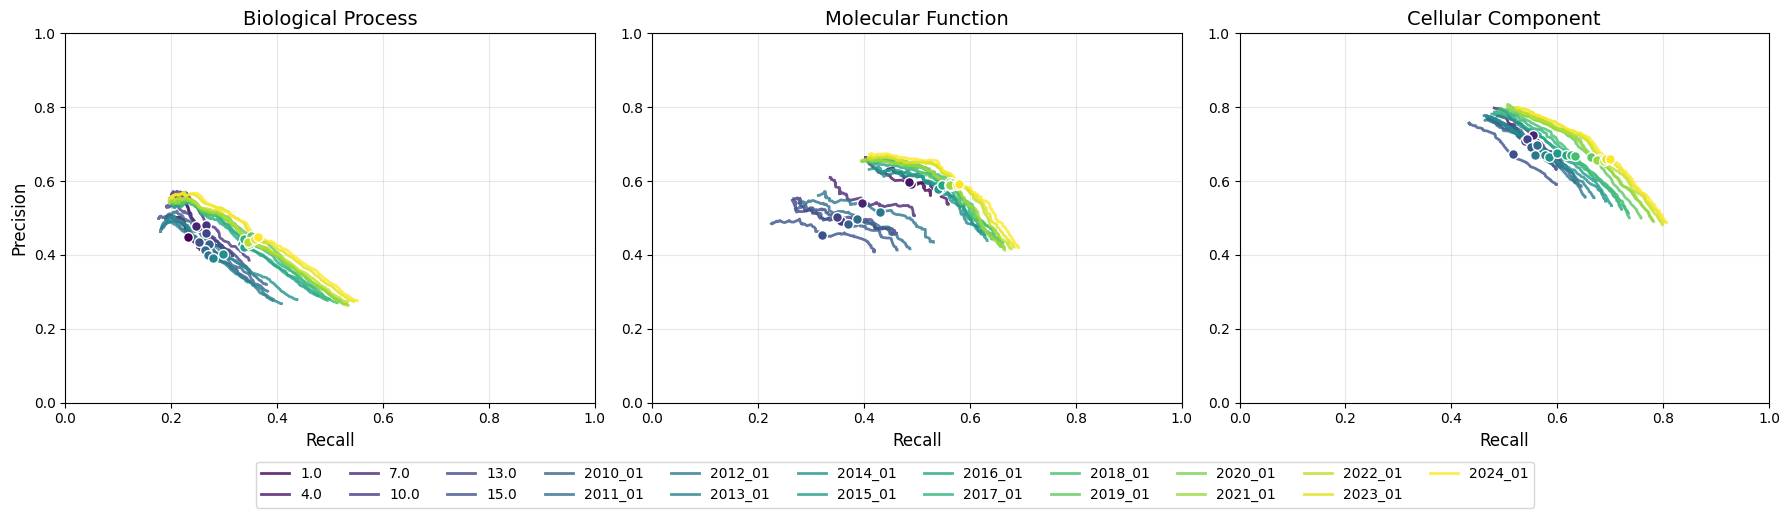

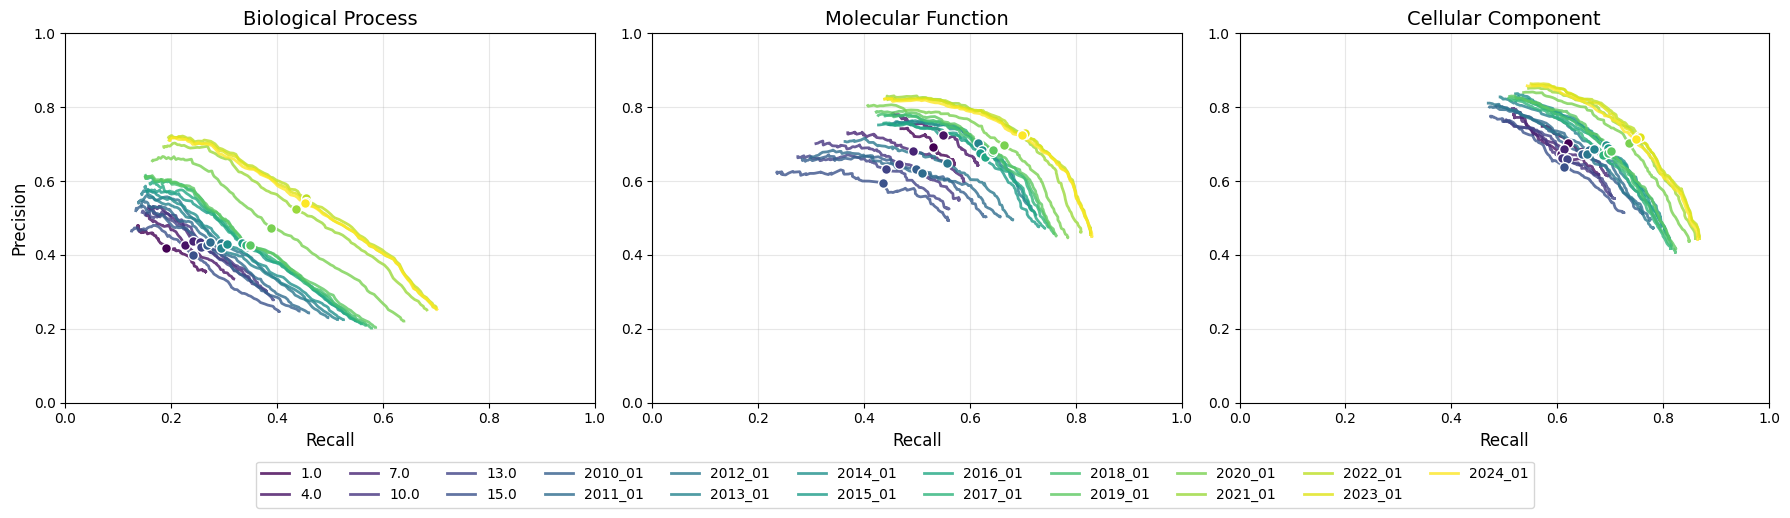

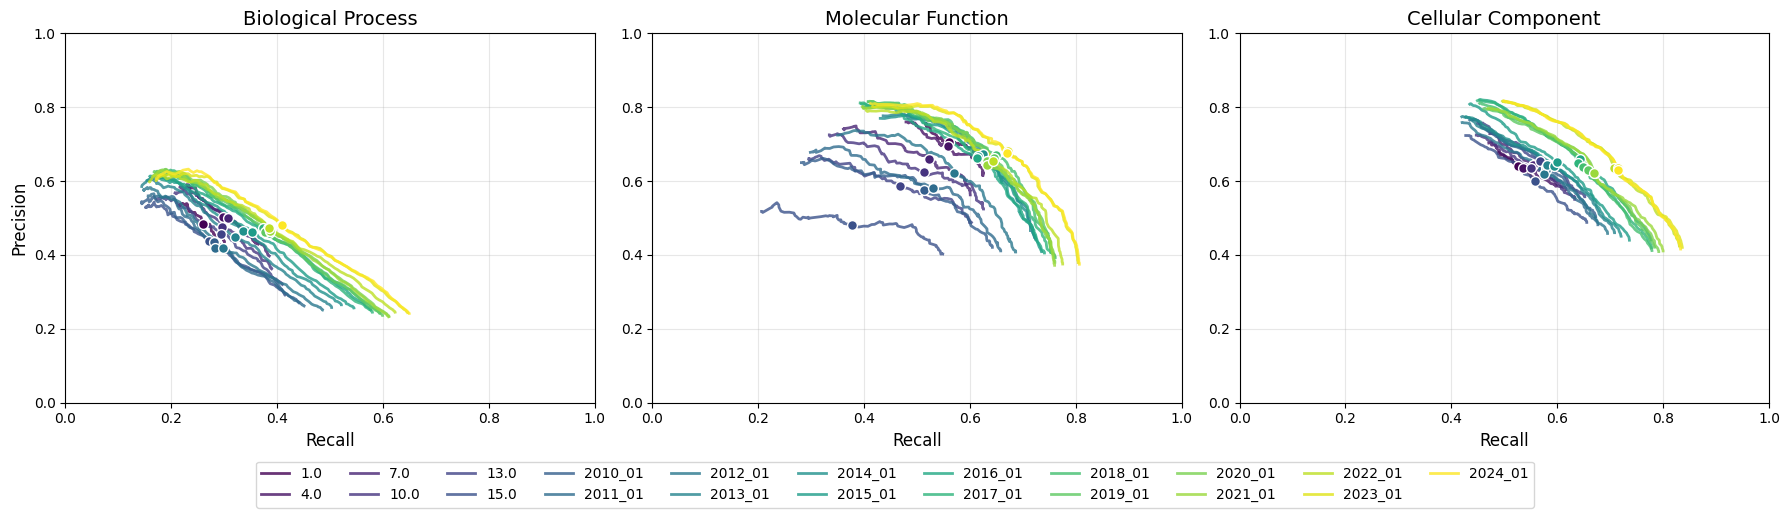

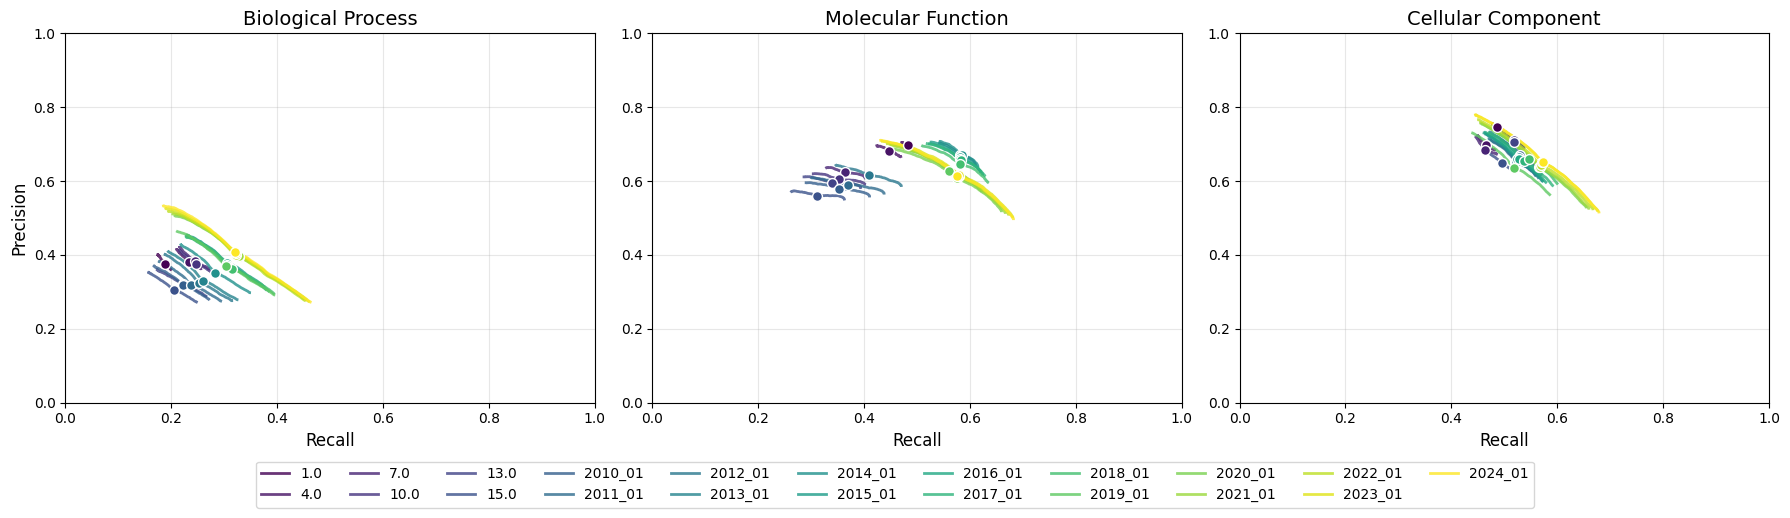

In [16]:
plot_pr_curves_evolution(DATASETS, metric_type='PR', show_fmax=True, onevsall=False)

/tmp/ipykernel_1429301/3607982059.py:182: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  results_dict[result_key] = np.trapz(precisions, recalls)
/tmp/ipykernel_1429301/3607982059.py:182: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  results_dict[result_key] = np.trapz(precisions, recalls)
/tmp/ipykernel_1429301/3607982059.py:182: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  results_dict[result_key] = np.trapz(precisions, recalls)
/tmp/ipykernel_1429301/3607982059.py:182: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  results_dict[result_key] = np.trapz(precisions, recalls)
/tmp/ipykernel_1429301/3607982059.py:182: Deprecatio

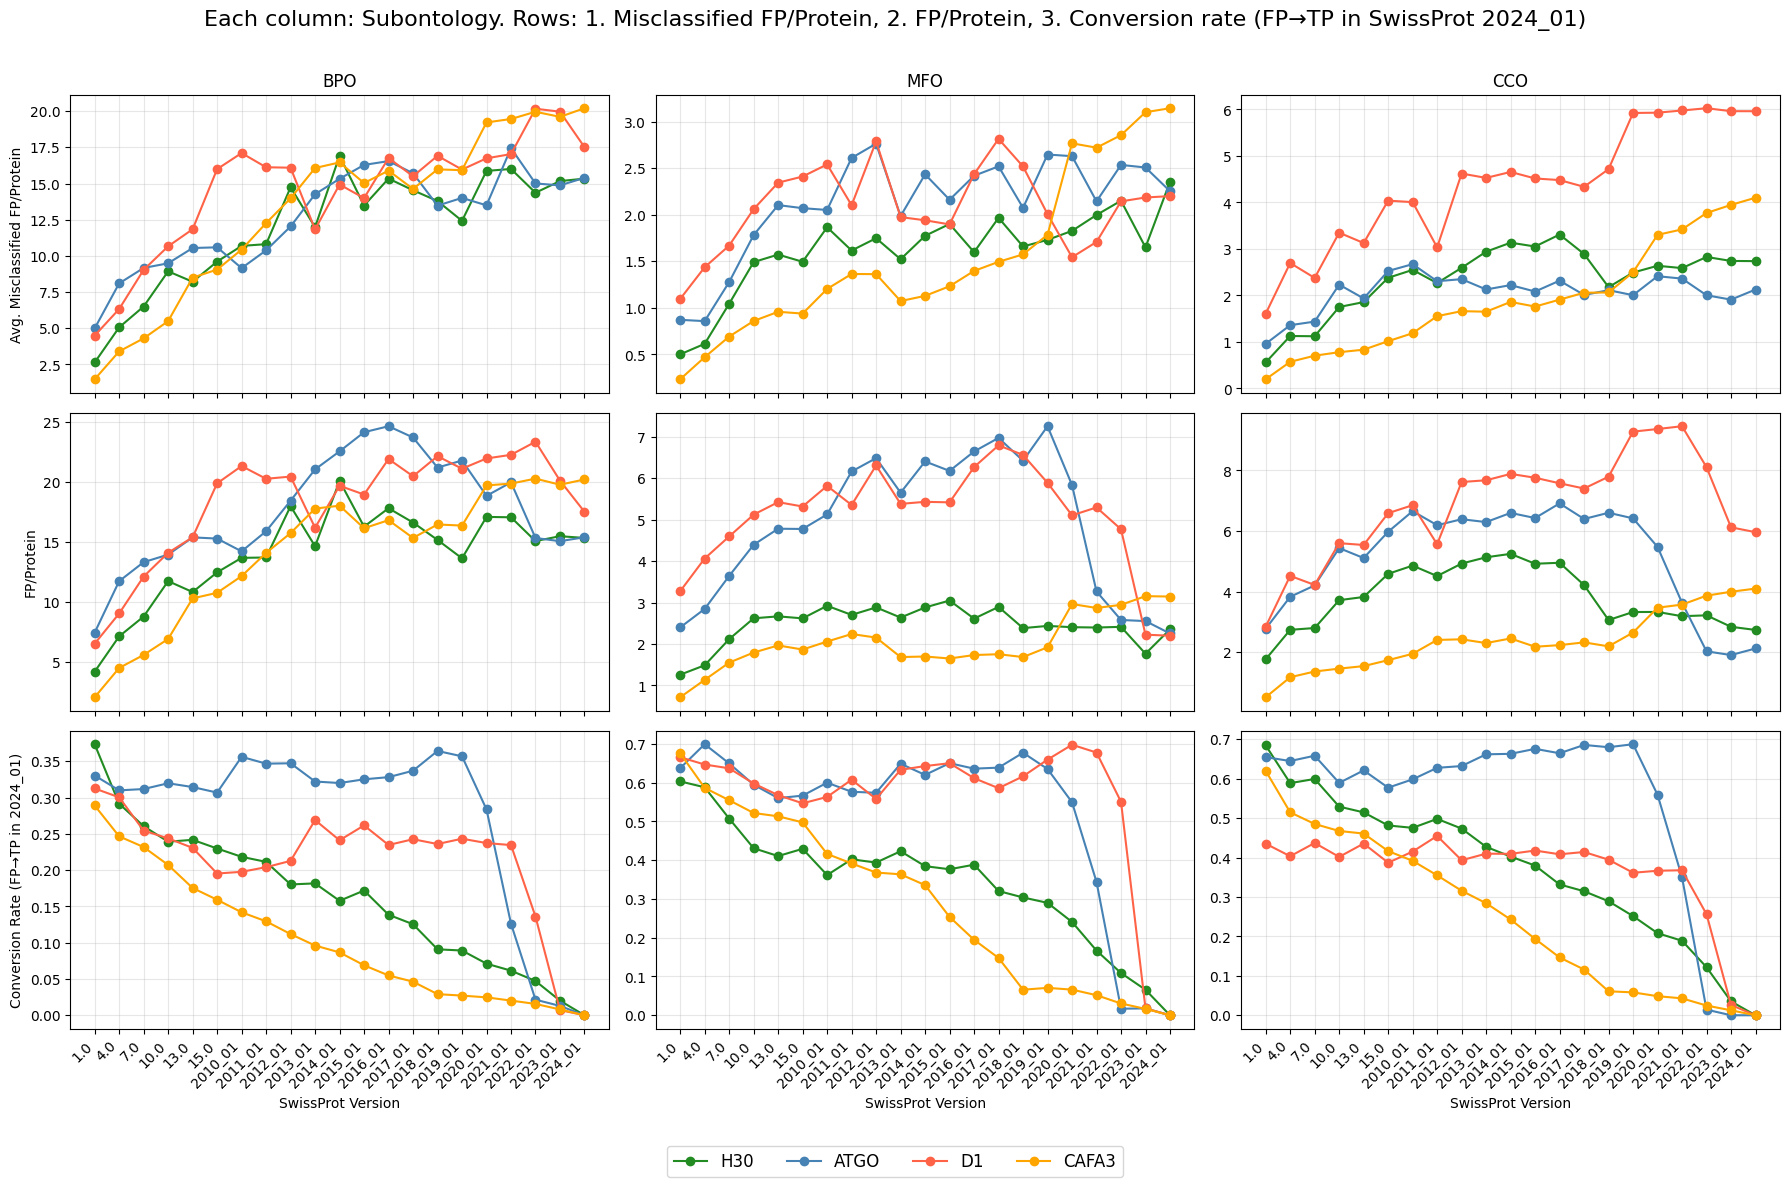

In [ ]:
def plot_fp_evolution_combined(dates, subontologies, datasets, onevsall=False, experimental_only=True):
    """
    Plot three metrics for each subontology in vertical subplots:
    1. Average False Positives per Protein
    2. Average Number of Misclassified False Positive per Protein
    3. Conversion rate (FP->TP in SwissProt 2024_01)
    """

    # Custom dataset colors
    dataset_colors = {
        'CAFA3': 'orange',
        'D1': 'tomato',
        'ATGO': 'steelblue',
        'H30': 'forestgreen'
    }

    id_mapping = pd.read_csv(
        f"../data/swissprot/2024_01/swissprot_2024_01_annotations.tsv",
        sep="\t",
        usecols=["EntryID", "Entry Name"],
    )
    id_mapping = id_mapping.set_index("Entry Name").to_dict()["EntryID"]

    # Precompute all values for each dataset/subontology/date
    results_dict = {}
    for sub in subontologies:
        results_dict[sub] = {}
        for dataset in datasets:
            color = dataset_colors.get(dataset, None)
            # Load 2024_01 dataset ground truth (filtered to proteins present in this dataset)
            gt_df = load_ground_truth(dataset, sub, experimental_only=experimental_only)
            test_proteins = set(gt_df['EntryID'])
            gt2024_df = load_ground_truth('swissprot', sub, '2024_01', experimental_only=experimental_only)
            if dataset in ['CAFA3', 'D1']:
                gt2024_df["EntryID"] = gt2024_df["EntryID"].map(id_mapping).fillna(gt2024_df["EntryID"])
            gt2024 = {entry for entry in gt2024_df[['EntryID', 'term']].itertuples(index=False, name=None) if entry[0] in test_proteins}

            fp_ratios = []
            fp_props = []
            avg_misclassified = []
            for date in dates:
                try:
                    pred = load_predictions(dataset, sub, date, method='AlignmentScore', use_2024_annotations=False, onevsall=onevsall, experimental_only=experimental_only)
                    results = load_evaluation_results(dataset, sub, date, method='AlignmentScore', use_2024_annotations=False, onevsall=onevsall, experimental_only=experimental_only)
                    t = results.get('result_t', np.nan) if results else np.nan

                    if pred is None or np.isnan(t):
                        fp_ratios.append(np.nan)
                        fp_props.append(np.nan)
                        avg_misclassified.append(np.nan)
                        continue

                    gt_df = load_ground_truth('swissprot', sub, date, experimental_only=experimental_only)
                    if dataset in ['CAFA3', 'D1']:
                        gt_df["EntryID"] = gt_df["EntryID"].map(id_mapping).fillna(gt_df["EntryID"])
                    gt_df = gt_df[gt_df['EntryID'].isin(test_proteins)]
                    gt = set(gt_df[['EntryID', 'term']].itertuples(index=False, name=None))
                    pred_above = set(pred.loc[pred['score'] >= t, ['target_ID', 'term_ID']].itertuples(index=False, name=None))

                    fp = pred_above - gt
                    became_tp = fp & gt2024
                    ratio_fp = len(became_tp) / len(fp) if len(fp) > 0 else np.nan
                    fp_ratios.append(ratio_fp)
                    fp_prop = len(fp) / len(test_proteins) if len(test_proteins) > 0 else np.nan
                    fp_props.append(fp_prop)
                    # Misclassified = FP per protein * (1 - conversion rate)
                    if not np.isnan(fp_prop) and not np.isnan(ratio_fp):
                        avg_misclassified.append(fp_prop * (1 - ratio_fp))
                    else:
                        avg_misclassified.append(np.nan)
                except Exception as e:
                    fp_ratios.append(np.nan)
                    fp_props.append(np.nan)
                    avg_misclassified.append(np.nan)
            results_dict[sub][dataset] = {
                "fp_props": fp_props,
                "avg_misclassified": avg_misclassified,
                "fp_ratios": fp_ratios,
                "color": color
            }

    fig, axes = plt.subplots(3, len(subontologies), figsize=(6 * len(subontologies), 12), sharex=True)

    metric_names = [
        ("avg_misclassified", "Avg. Misclassified FP/Protein"),
        ("fp_props", "FP/Protein"),
        ("fp_ratios", "Conversion Rate (FP→TP in 2024_01)")
    ]

    for col, sub in enumerate(subontologies):
        for row, (metric_key, ylabel) in enumerate(metric_names):
            ax = axes[row, col]
            for dataset in datasets:
                color = results_dict[sub][dataset]["color"]
                values = results_dict[sub][dataset][metric_key]
                (line,) = ax.plot(
                    dates, values,
                    marker='o', linestyle='-',
                    label=f"{dataset}", color=color
                )
            if col == 0:
                ax.set_ylabel(ylabel)
            if row == 2:
                ax.set_xlabel('SwissProt Version')
            ax.set_title(sub if row == 0 else "")
            ax.tick_params(axis='x', rotation=45)
            ax.set_xticks(range(len(dates)))
            ax.set_xticklabels(dates, rotation=45, ha='right')
            ax.grid(True, alpha=0.3)

    handles = []
    labels = []
    for dataset in datasets:
        if dataset in results_dict[subontologies[0]]:
            color = results_dict[subontologies[0]][dataset]["color"]
            line = plt.Line2D([0], [0], color=color, marker='o', linestyle='-')
            handles.append(line)
            labels.append(dataset)
    fig.legend(handles, labels, ncol=4, fontsize=12, loc='lower center', bbox_to_anchor=(0.5, 0.00))
    plt.suptitle("Each column: Subontology. Rows: 1. Misclassified FP/Protein, 2. FP/Protein, 3. Conversion rate (FP→TP in SwissProt 2024_01)", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.97])
    plt.show()

# Usage:
plot_fp_evolution_combined(SWISSPROT_VERSIONS, SUBONTOLOGIES, DATASETS, onevsall=False)
#